In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, GRU, Dropout, Dense

from google.colab import files

In [3]:
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

In [5]:
goog = pd.read_csv('/content/drive/MyDrive/Data_science/MP2/GOOG.csv', sep='\t', parse_dates=[0])
aapl = pd.read_csv('/content/drive/MyDrive/Data_science/MP2/AAPL.csv', sep='\t', parse_dates=[0])
company_names = ["GooG", "AAPL"]

In [6]:
goog.isnull().sum()


Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [7]:

aapl.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [9]:
goog.describe()

<bound method NDFrame.head of            Date         High          Low         Open        Close  \
0    2010-01-04   313.579620   310.954468   312.304413   312.204773   
1    2010-01-05   312.747742   309.609497   312.418976   310.829926   
2    2010-01-06   311.761444   302.047852   311.761444   302.994293   
3    2010-01-07   303.861053   295.218445   303.562164   295.940735   
4    2010-01-08   300.498657   293.455048   294.894653   299.885956   
...         ...          ...          ...          ...          ...   
2259 2018-12-24  1003.539978   970.109985   973.900024   976.219971   
2260 2018-12-26  1040.000000   983.000000   989.010010  1039.459961   
2261 2018-12-27  1043.890015   997.000000  1017.150024  1043.880005   
2262 2018-12-28  1055.560059  1033.099976  1049.619995  1037.079956   
2263 2018-12-31  1052.699951  1023.590027  1050.959961  1035.609985   

          Volume    Adj Close  
0      3927000.0   312.204773  
1      6031900.0   310.829926  
2      7987100.0   30

In [11]:
goog.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

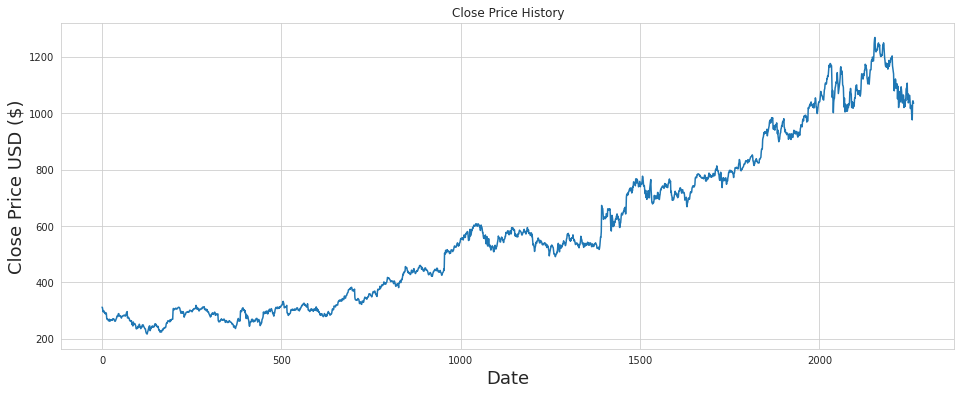

In [12]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(goog['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [24]:
# choosing data

KeyError: ignored

In [20]:
goog["Date"]

0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
2259   2018-12-24
2260   2018-12-26
2261   2018-12-27
2262   2018-12-28
2263   2018-12-31
Name: Date, Length: 2264, dtype: datetime64[ns]

In [27]:
close_goog = goog["Close"].to_numpy().reshape(-1,1)
close_aapl = aapl["Close"].to_numpy().reshape(-1,1)

In [50]:
dataset_y = np.hstack((close_goog, close_aapl)) # first col is for goog and the second one is for aapl
dataset = np.hstack((goog.drop(goog.columns[0], axis=1).to_numpy().reshape(-1,6), aapl.drop(aapl.columns[0], axis=1).to_numpy().reshape(-1,6)))

In [51]:
dataset.shape

(2264, 12)

In [47]:
train_percenatge = 0.7;
train_dataset = dataset[0:int(0.7*len(dataset)), :]
valid_dataset = dataset[int(0.7*len(dataset)):int(0.85*len(dataset)), :]
test_dataset = dataset[int(0.85*len(dataset)):, :]

In [48]:
len(train_dataset) + len(valid_dataset) + len(test_dataset)

2264

In [49]:
train_dataset[:, 0]

array([313.57962036, 312.7477417 , 311.76144409, ..., 761.        ,
       768.04998779, 769.90002441])

In [91]:
# scaling the dataset
scaler = MinMaxScaler(feature_range = (0.001, 1))
scaler_y = [MinMaxScaler(feature_range = (0.001, 1)), MinMaxScaler(feature_range = (0.001, 1))]


train_dataset_scaled = np.zeros_like(train_dataset)
valid_dataset_scaled = np.zeros_like(valid_dataset)
test_dataset_scaled = np.zeros_like(test_dataset)


train_dataset_scaled = scaler.fit_transform(train_dataset)
valid_dataset_scaled = scaler.transform(valid_dataset)
test_dataset_scaled = scaler.transform(test_dataset)

counter = 0
for i in [3,9]:
  train_dataset_scaled[:, i] = scaler_y[counter].fit_transform(train_dataset[:, i].reshape(-1,1)).reshape(1,-1)
  valid_dataset_scaled[:, i] = scaler_y[counter].transform(valid_dataset[:, i].reshape(-1,1)).reshape(1,-1)
  test_dataset_scaled[:, i] = scaler_y[counter].transform(test_dataset[:, i].reshape(-1,1)).reshape(1,-1)
  counter = counter + 1

In [92]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps
		if end_ix > len(sequences)-1:
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		seq_y = [seq_y[3], seq_y[9]]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [93]:
back_days = 30
forward_days = 1
# converting to 30 days sequences

X_train, y_train = split_sequences(train_dataset_scaled, n_steps=back_days)
X_valid, y_valid = split_sequences(valid_dataset_scaled, n_steps=back_days)
X_test, y_test = split_sequences(test_dataset_scaled, n_steps=back_days)

In [94]:
X_train.shape

(1554, 30, 12)

In [95]:
y_train.shape

(1554, 2)

# Functions

In [96]:
def create_model(model_name, activation, optimizer, loss_function, dropout, recurrent_dropout, back_days, feature_size):
  model = Sequential()
  # input layers
  if model_name == "RNN":
    model.add(SimpleRNN(100, activation=activation, dropout=dropout, recurrent_dropout=recurrent_dropout, input_shape=(back_days, feature_size)))
  elif model_name == "LSTM":
    model.add(LSTM(100, activation=activation, dropout=dropout, recurrent_dropout=recurrent_dropout, input_shape=(back_days, feature_size)))
  elif model_name == "GRU":
    model.add(GRU(100, activation=activation, dropout=dropout, recurrent_dropout=recurrent_dropout, input_shape=(back_days, feature_size)))
  
  model.add(Dense(2))
  model.compile(optimizer=optimizer, loss=loss_function, metrics=['mse', "mape"])

  return model, model.summary()

In [99]:
from keras.callbacks import ModelCheckpoint
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1, min_delta=0.0001, min_lr = 1e-8)
def run_models(X_train, y_train, X_test, y_test, model_config, desired_hyper_par, suptitle):
  output_table = dict(model_name=[], epochs=[], batch_size=[], loss=[], mse=[], mape=[], training_time=[], activation=[], optimizer=[], loss_function=[], dropout=[], recurrent_dropout=[])
  main_main_title = suptitle + desired_hyper_par
  if os.path.exists(main_main_title):
    os.system( "rm -rf {}".format(main_main_title))
  os.mkdir(main_main_title)

  for i in range(0, len(model_config['epochs'])):
    main_title = desired_hyper_par + "={}".format(model_config[desired_hyper_par][i])
    
    model, model_summary = create_model(model_name=model_config["model_name"][i], 
                                        activation=model_config["activation"][i], 
                                        optimizer=model_config["optimizer"][i], 
                                        loss_function=model_config["loss_function"][i], 
                                        dropout=model_config["dropout"][i], 
                                        recurrent_dropout=model_config["recurrent_dropout"][i], 
                                        back_days=X_train.shape[1], 
                                        feature_size=X_train.shape[2])

    start = time.time()
    train_history = model.fit(x=X_train,
            y=y_train,
            batch_size=model_config['batch_size'][i],
            epochs=model_config['epochs'][i],
            validation_data = (X_valid,y_valid),
            callbacks=[reduce_lr],
            )
    end = time.time()
    run_time = end - start

    output_table['training_time'].append(run_time)

    y_predicted_scaled= model.predict(X_test)
    test_history = model.evaluate(X_test, y_test, return_dict=True)

    for keys in model_config.keys():
      output_table[keys].append(model_config[keys][i])

    for keys in test_history.keys():  
      output_table[keys].append(test_history[keys])

    y_predicted_real = np.zeros_like(y_predicted_scaled)
    y_test_real = np.zeros_like(y_test)


    for k in [0, 1]:
      y_predicted_real[:, k] = scaler_y[k].inverse_transform(y_predicted_scaled[:, k].reshape(-1,1)).reshape(1,-1)
      y_test_real[:, k] = scaler_y[k].inverse_transform(y_test[:, k].reshape(-1,1)).reshape(1,-1)


    epochs = model_config['epochs'][i]


    plt.figure(figsize=(5, 5)) 
    plt.plot(range(0,epochs), train_history.history['loss'][:epochs], label='Training')
    plt.plot(range(0,epochs), train_history.history['val_loss'][:epochs], label='validation')
    plt.title('Training and Validation loss')
    plt.suptitle(main_title)
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    sns.despine()
    plt.savefig(main_main_title + '/summary_' + main_title + '.png')



    plt.figure(figsize=(10, 10))
    for j in range(y_test_real.shape[1]):
      plt.subplot(2, 1, j+1)
      plt.scatter(y_test_real[:,j], y_predicted_real[:,j])
      plt.title(company_names[j])
      plt.xlabel('Real')
      plt.ylabel('Predicted')
      plt.legend()
      sns.despine()

    plt.suptitle('Real against Preidicted close value_' + main_title)
    plt.savefig(main_main_title + '//real_against_pred_' + main_title + '.png')



    plt.figure(figsize=(25, 15))
    for j in range(y_test_real.shape[1]):
      plt.subplot(2, 1, j+1)
      plt.plot(y_test_real[:,j], 'o', label='Real value')
      plt.plot(y_predicted_real[:,j], '-x', label='Predicted value')
      plt.xlabel('Days')
      plt.ylabel('Close price')
      plt.title(company_names[j])
      sns.despine()
      plt.legend()

    plt.suptitle('Real vs Preidicted close value_' + main_title)
    plt.savefig(main_main_title + '/real_vs_pred_' + main_title + '.png')


    model.save(main_main_title  + main_title)


  df = pd.DataFrame(output_table)
  df.to_csv(main_main_title + '/summary_' + main_main_title + '.csv', index=False)

  os.system( "zip -r {} {}".format(main_main_title + ".zip", main_main_title))
  files.download(main_main_title + ".zip")

## MAPE as the loss function

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 100)               11300     
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 11,502
Trainable params: 11,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 4s 24ms/step - loss: 0.0192 - mse: 0.0192 - mape: 19.5954 - val_loss: 6.8704e-04 - val_mse: 6.8704e-04 - val_mape: 2.1376 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 14ms/step - loss: 4.8013e-04 - mse: 4.8013e-04 - mape: 7.6155 - val_loss: 5.1251e-04 - val_mse: 5.1251e-04 - val_mape: 1.7295 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 15ms

INFO:tensorflow:Assets written to: V9-all-features-msemodel_namemodel_name=RNN/assets


INFO:tensorflow:Assets written to: V9-all-features-msemodel_namemodel_name=RNN/assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               45200     
                                                                 
 dense_6 (Dense)             (None, 2)                 202       
                                                                 
Total params: 45,402
Trainable params: 45,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 22ms/step - loss: 0.0233 - mse: 0.0233 - mape: 25.1120 - val_loss: 0.0064 - val_mse: 0.0064 - val_mape: 5.2539 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 20ms/step - loss: 6.2214e-04 - mse: 6.2214e-04 - mape: 9.2369 - val_loss: 0.0031 - val_mse: 0.0031 - val_mape: 3.7644 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 20ms/step - loss: 5.

INFO:tensorflow:Assets written to: V9-all-features-msemodel_namemodel_name=LSTM/assets


INFO:tensorflow:Assets written to: V9-all-features-msemodel_namemodel_name=LSTM/assets


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 100)               34200     
                                                                 
 dense_7 (Dense)             (None, 2)                 202       
                                                                 
Total params: 34,402
Trainable params: 34,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 25ms/step - loss: 0.0259 - mse: 0.0259 - mape: 34.2021 - val_loss: 9.1330e-04 - val_mse: 9.1330e-04 - val_mape: 2.4704 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 3s 23ms/step - loss: 3.2416e-04 - mse: 3.2416e-04 - mape: 7.6223 - val_loss: 5.9595e-04 - val_mse: 5.9595e-04 - val_mape: 1.9124 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 3s 23ms

INFO:tensorflow:Assets written to: V9-all-features-msemodel_namemodel_name=GRU/assets


INFO:tensorflow:Assets written to: V9-all-features-msemodel_namemodel_name=GRU/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

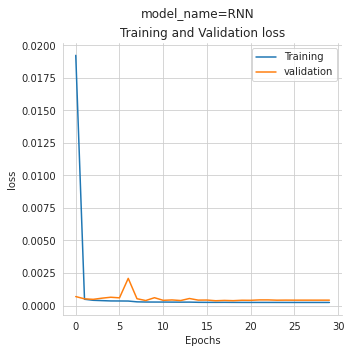

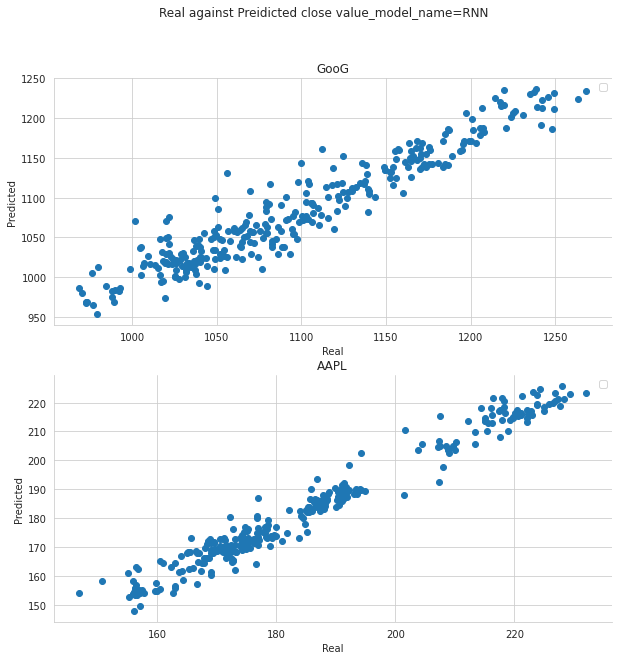

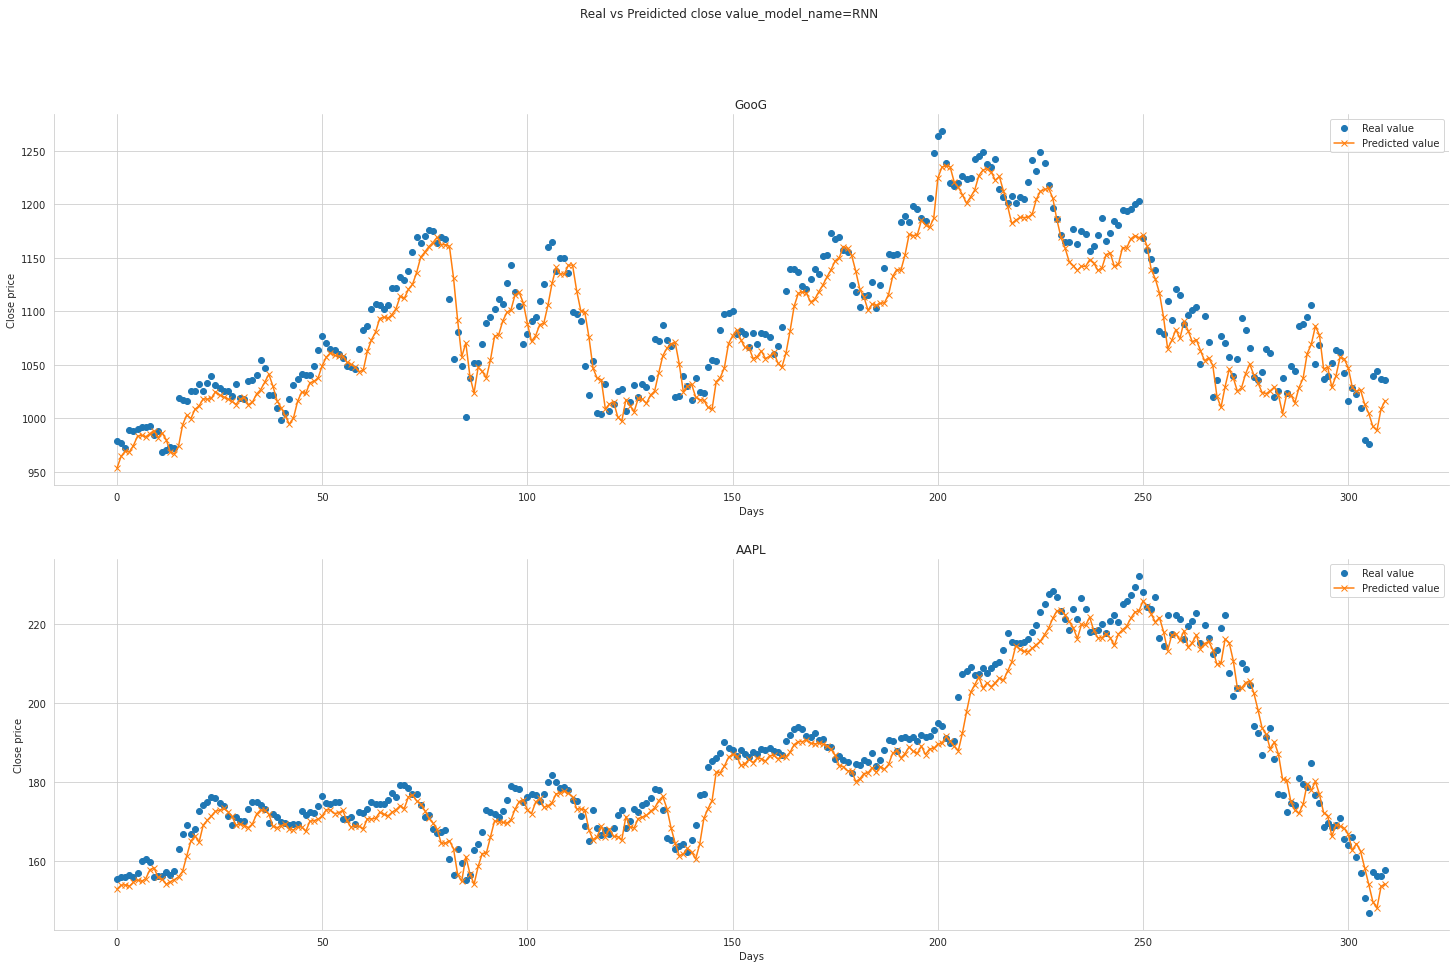

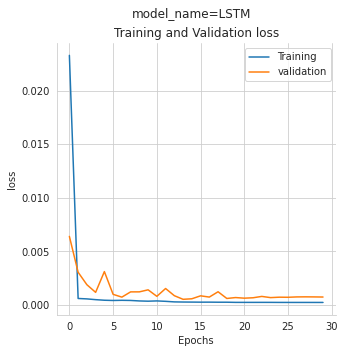

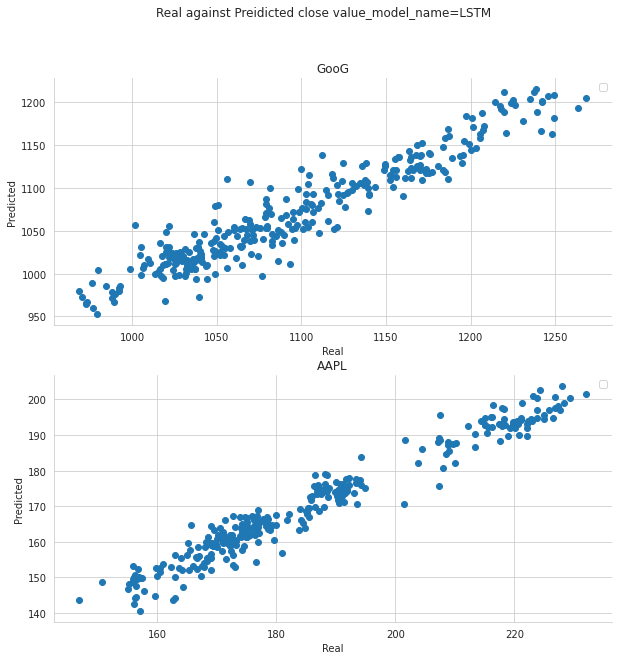

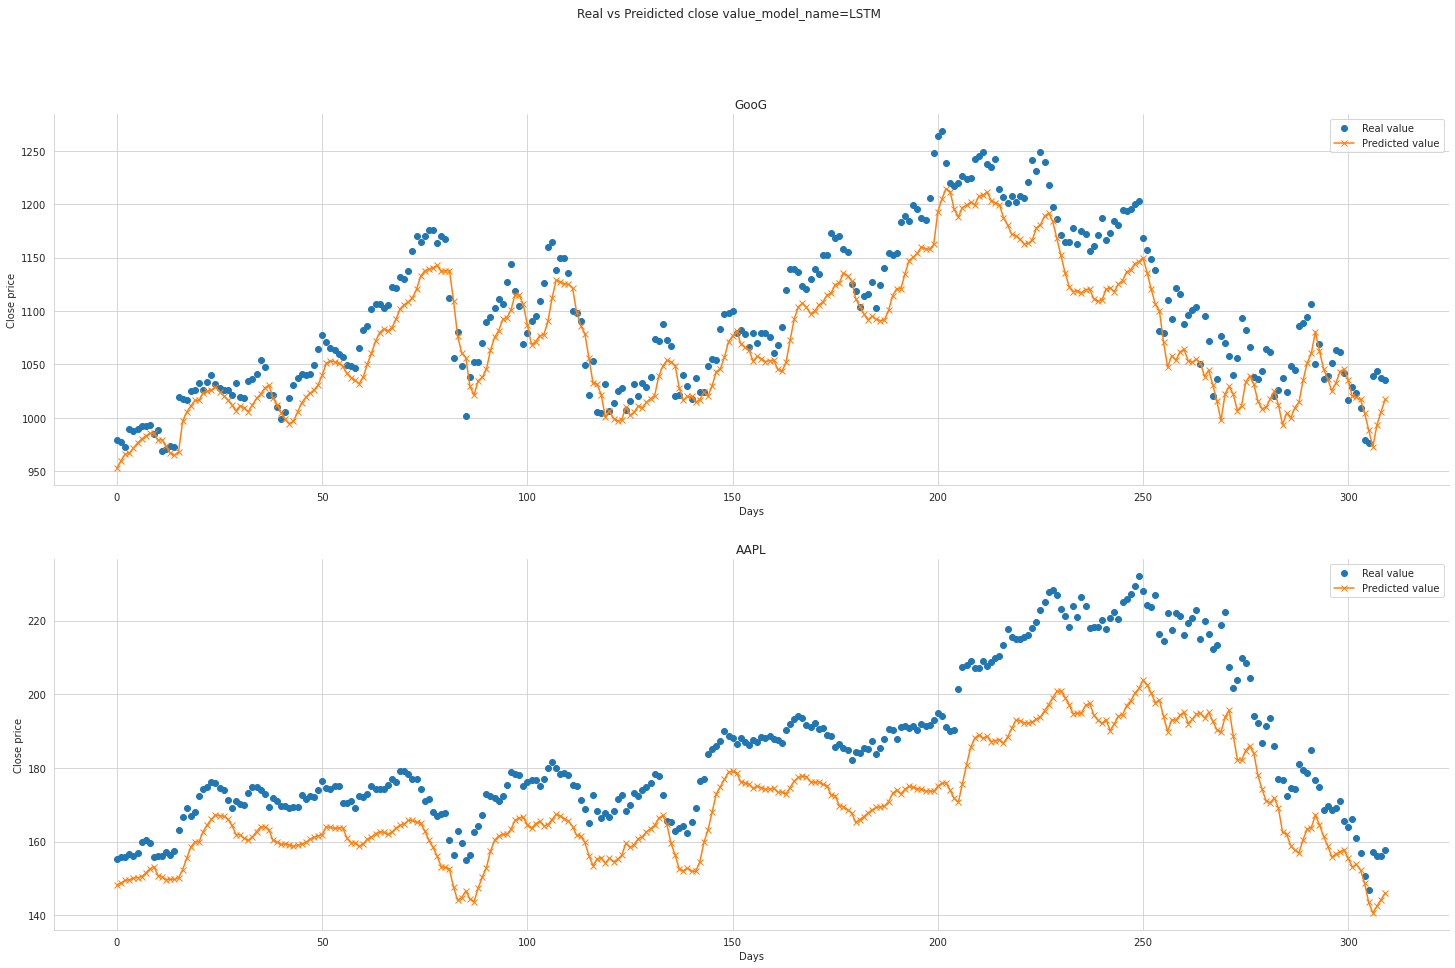

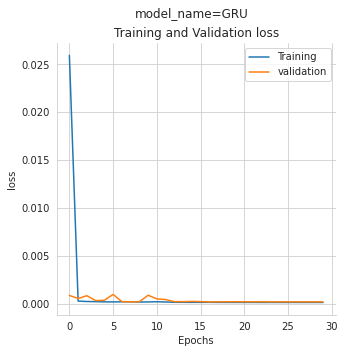

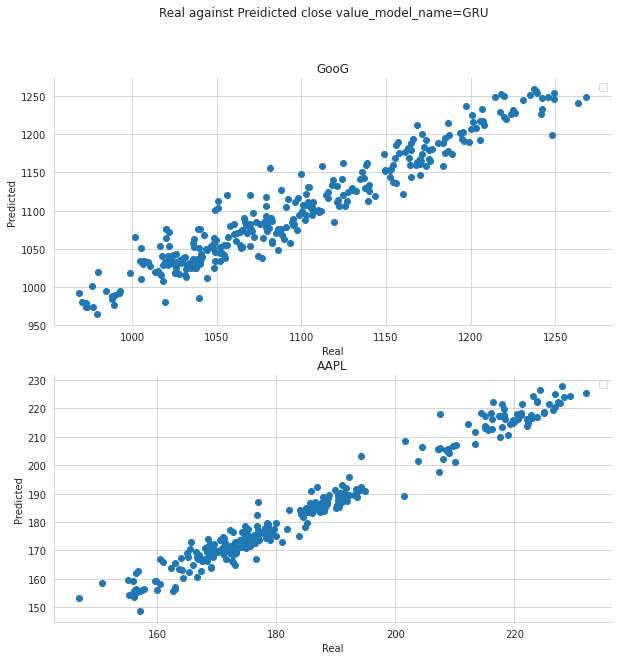

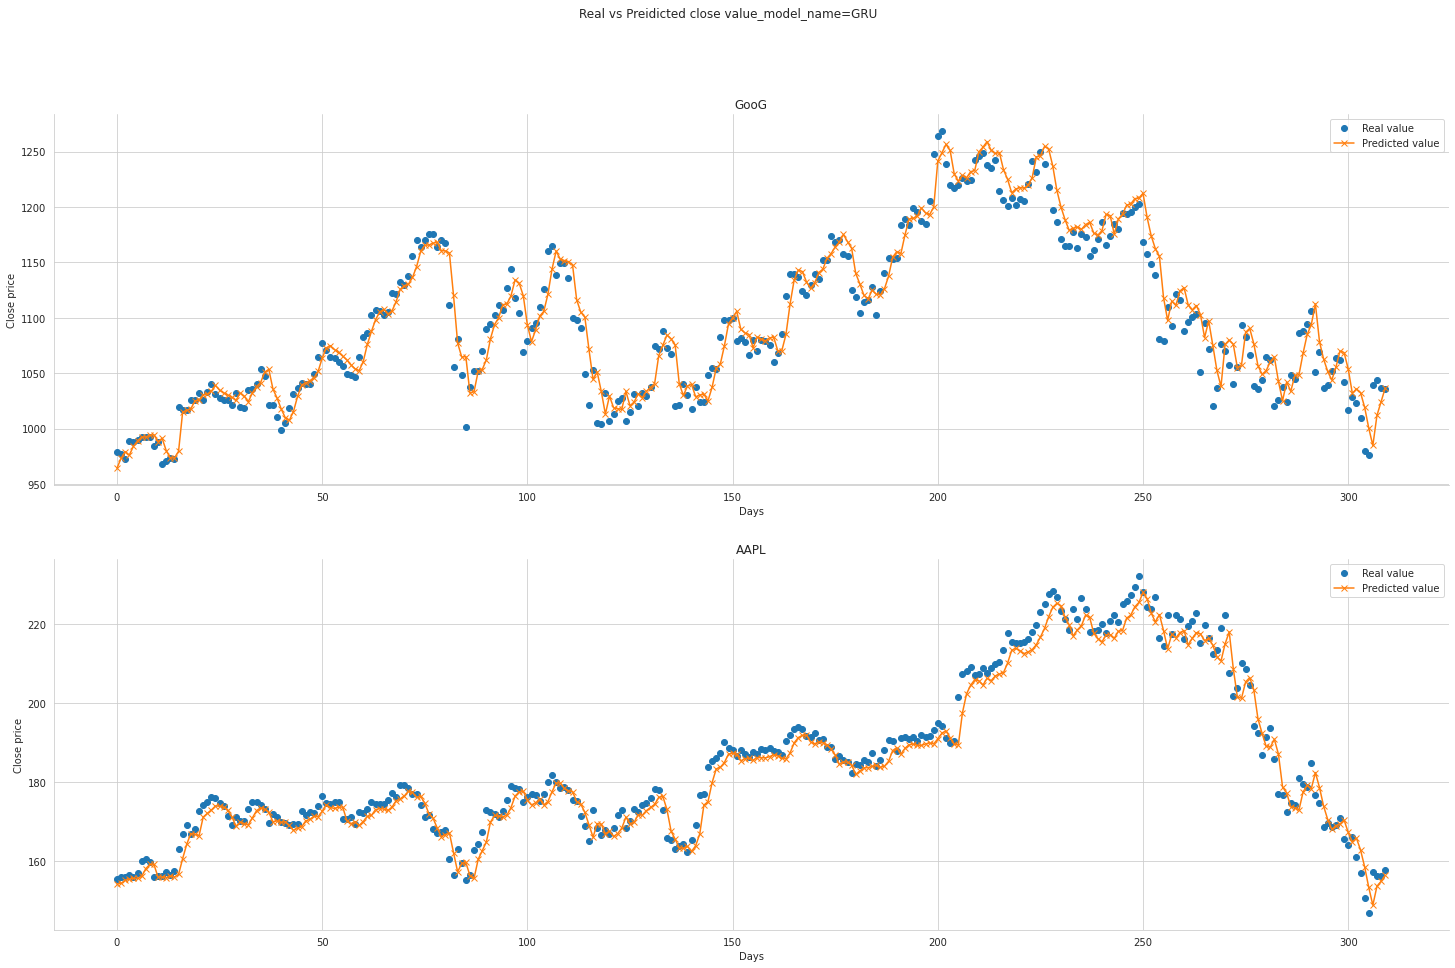

In [101]:
model_config = dict(model_name=["RNN", "LSTM", "GRU"], epochs=[30,30,30], batch_size=[14,14,14], activation=['relu', 'relu','relu'], optimizer=['adam','adam','adam'], loss_function=['mse','mse','mse'], dropout=[0,0,0], recurrent_dropout=[0,0,0])
desired_hyper_par = "model_name"
suptitle = "V9-all-features-mse"
run_models(X_train, y_train, X_test, y_test, model_config, desired_hyper_par, suptitle)

# Optimizers

RNN

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 100)               11300     
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 11,502
Trainable params: 11,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 2s 17ms/step - loss: 16.1930 - mse: 0.0036 - mape: 16.1930 - val_loss: 4.4719 - val_mse: 0.0022 - val_mape: 4.4719 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 14ms/step - loss: 10.5025 - mse: 6.9139e-04 - mape: 10.5025 - val_loss: 2.0386 - val_mse: 5.9029e-04 - val_mape: 2.0386 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 14ms/step - loss:

INFO:tensorflow:Assets written to: RNNoptimizeroptimizer=adam/assets


INFO:tensorflow:Assets written to: RNNoptimizeroptimizer=adam/assets


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 100)               11300     
                                                                 
 dense_10 (Dense)            (None, 2)                 202       
                                                                 
Total params: 11,502
Trainable params: 11,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 2s 16ms/step - loss: 13.6127 - mse: 0.0035 - mape: 13.6127 - val_loss: 1.9064 - val_mse: 6.0247e-04 - val_mape: 1.9064 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 14ms/step - loss: 9.2658 - mse: 6.6410e-04 - mape: 9.2658 - val_loss: 1.7599 - val_mse: 5.1994e-04 - val_mape: 1.7599 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 14ms/step - lo

INFO:tensorflow:Assets written to: RNNoptimizeroptimizer=ADAgrad/assets


INFO:tensorflow:Assets written to: RNNoptimizeroptimizer=ADAgrad/assets


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 100)               11300     
                                                                 
 dense_11 (Dense)            (None, 2)                 202       
                                                                 
Total params: 11,502
Trainable params: 11,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 16ms/step - loss: 16.3657 - mse: 0.0040 - mape: 16.3657 - val_loss: 3.5217 - val_mse: 0.0016 - val_mape: 3.5217 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 15ms/step - loss: 10.6456 - mse: 0.0011 - mape: 10.6456 - val_loss: 1.6869 - val_mse: 4.5890e-04 - val_mape: 1.6869 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 14ms/step - loss: 8.

INFO:tensorflow:Assets written to: RNNoptimizeroptimizer=RMSprop/assets


INFO:tensorflow:Assets written to: RNNoptimizeroptimizer=RMSprop/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

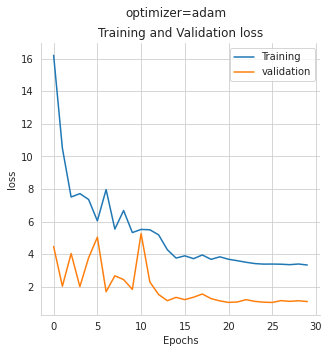

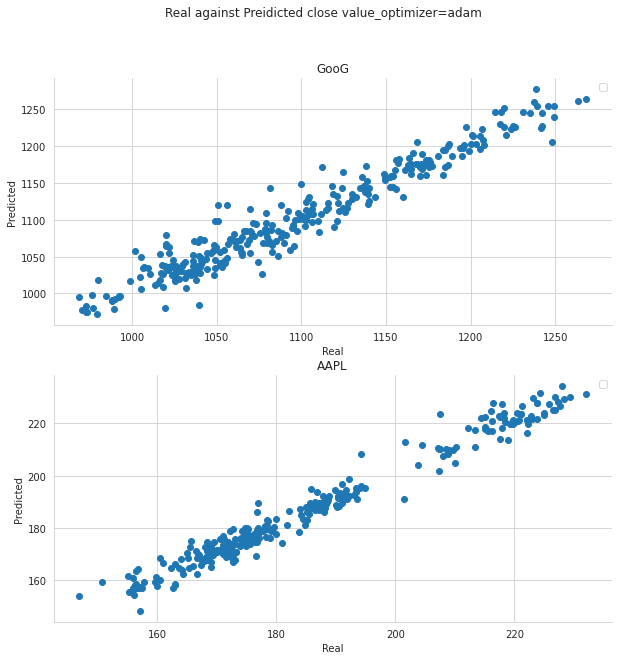

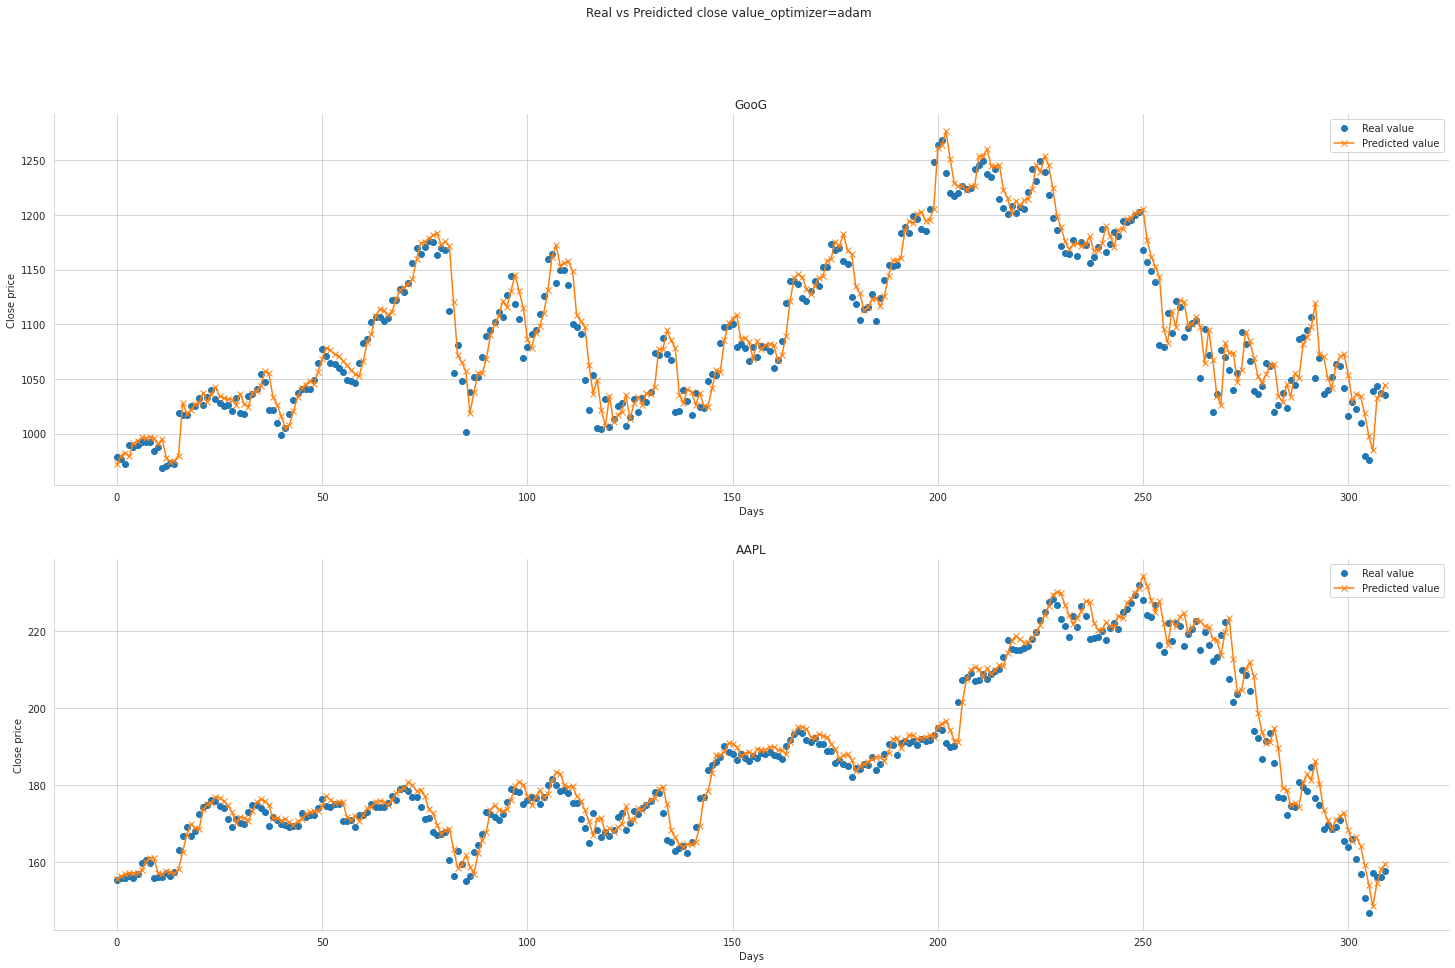

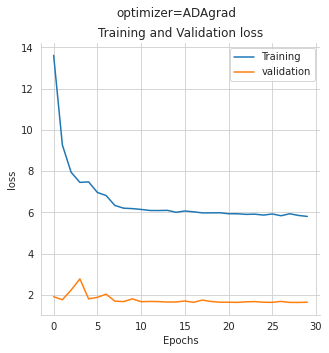

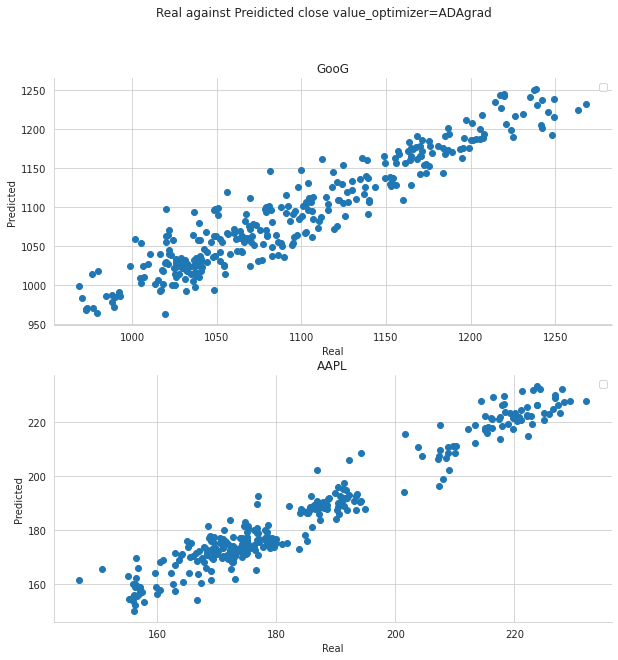

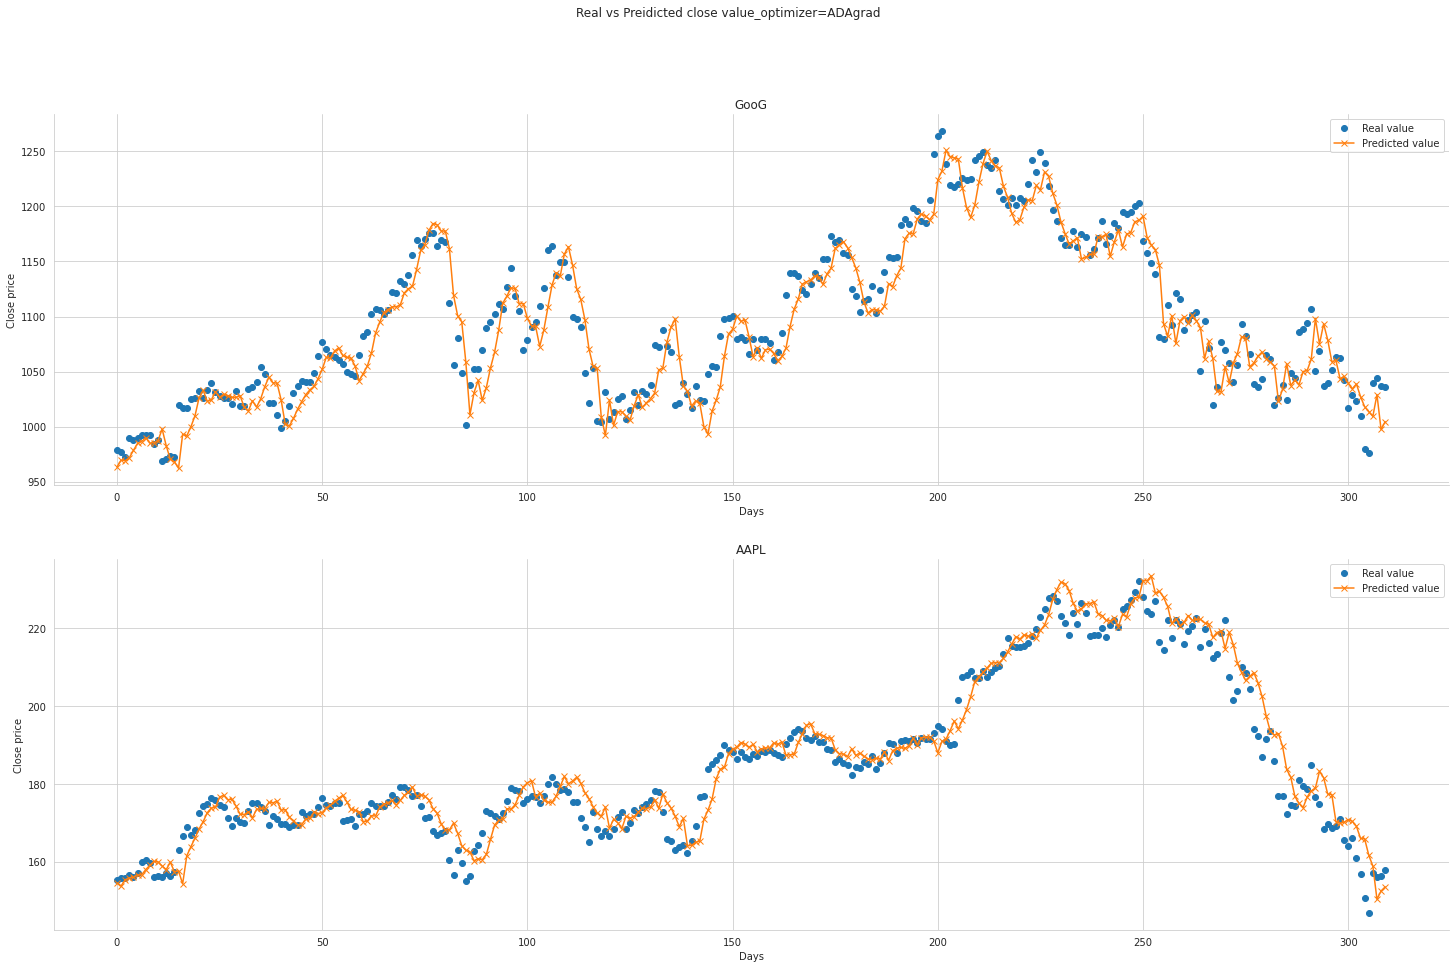

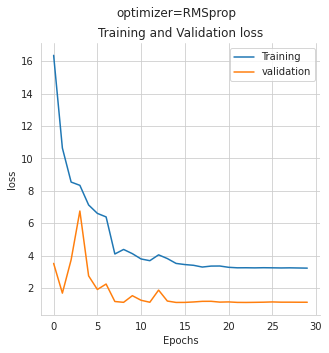

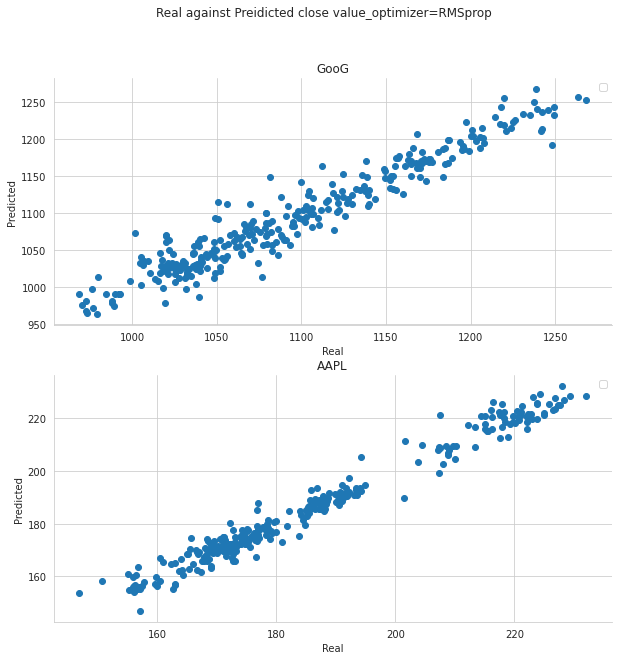

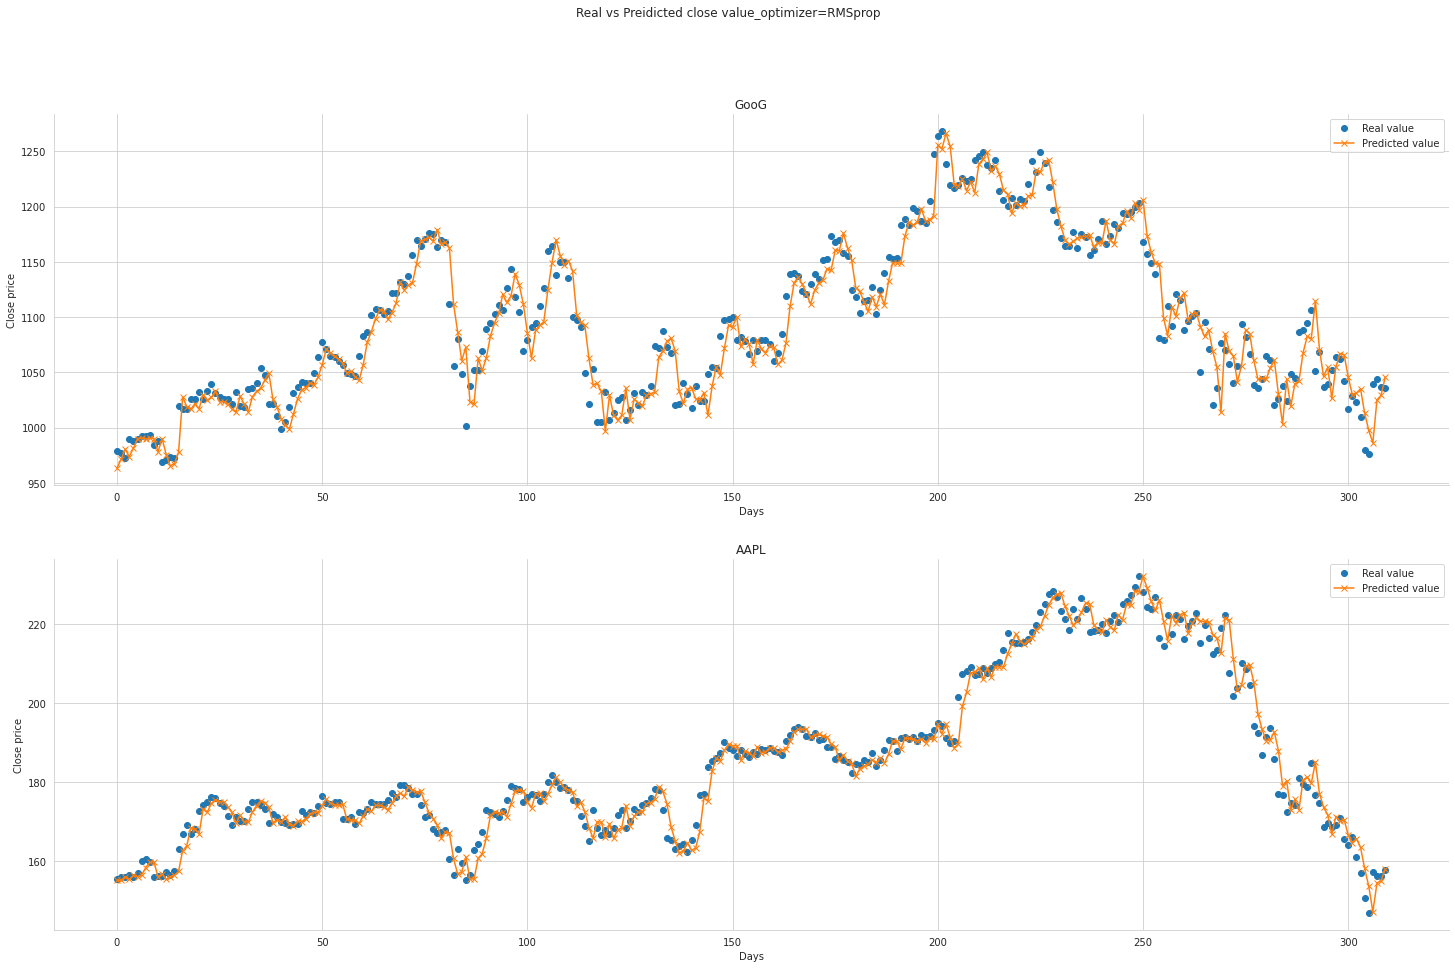

In [103]:
model_config = dict(model_name=["RNN", "RNN", "RNN"], epochs=[30,30,30], batch_size=[14,14,14], activation=['relu', 'relu','relu'], optimizer=['adam','ADAgrad','RMSprop'], loss_function=['mape','mape','mape'], dropout=[0,0,0], recurrent_dropout=[0,0,0])
desired_hyper_par = "optimizer"
suptitle = "RNN"
run_models(X_train, y_train, X_test, y_test, model_config, desired_hyper_par, suptitle)

LSTM

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               45200     
                                                                 
 dense_12 (Dense)            (None, 2)                 202       
                                                                 
Total params: 45,402
Trainable params: 45,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 23ms/step - loss: 20.2640 - mse: 0.0155 - mape: 20.2640 - val_loss: 7.2911 - val_mse: 0.0094 - val_mape: 7.2911 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 21ms/step - loss: 8.6488 - mse: 0.0011 - mape: 8.6488 - val_loss: 4.0057 - val_mse: 0.0035 - val_mape: 4.0057 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 21ms/step - loss: 9.2139 -

INFO:tensorflow:Assets written to: LSTMoptimizeroptimizer=adam/assets


INFO:tensorflow:Assets written to: LSTMoptimizeroptimizer=adam/assets


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               45200     
                                                                 
 dense_13 (Dense)            (None, 2)                 202       
                                                                 
Total params: 45,402
Trainable params: 45,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 23ms/step - loss: 24.2987 - mse: 0.0269 - mape: 24.2987 - val_loss: 8.4385 - val_mse: 0.0181 - val_mape: 8.4385 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 20ms/step - loss: 9.4876 - mse: 9.3809e-04 - mape: 9.4876 - val_loss: 3.4404 - val_mse: 0.0021 - val_mape: 3.4404 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 20ms/step - loss: 8.04

INFO:tensorflow:Assets written to: LSTMoptimizeroptimizer=ADAgrad/assets


INFO:tensorflow:Assets written to: LSTMoptimizeroptimizer=ADAgrad/assets


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               45200     
                                                                 
 dense_14 (Dense)            (None, 2)                 202       
                                                                 
Total params: 45,402
Trainable params: 45,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 23ms/step - loss: 17.2375 - mse: 0.0080 - mape: 17.2375 - val_loss: 7.0029 - val_mse: 0.0067 - val_mape: 7.0029 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 2s 21ms/step - loss: 10.8524 - mse: 0.0017 - mape: 10.8524 - val_loss: 5.0480 - val_mse: 0.0033 - val_mape: 5.0480 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 21ms/step - loss: 9.2709

INFO:tensorflow:Assets written to: LSTMoptimizeroptimizer=RMSprop/assets


INFO:tensorflow:Assets written to: LSTMoptimizeroptimizer=RMSprop/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

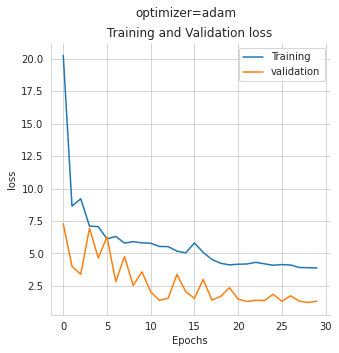

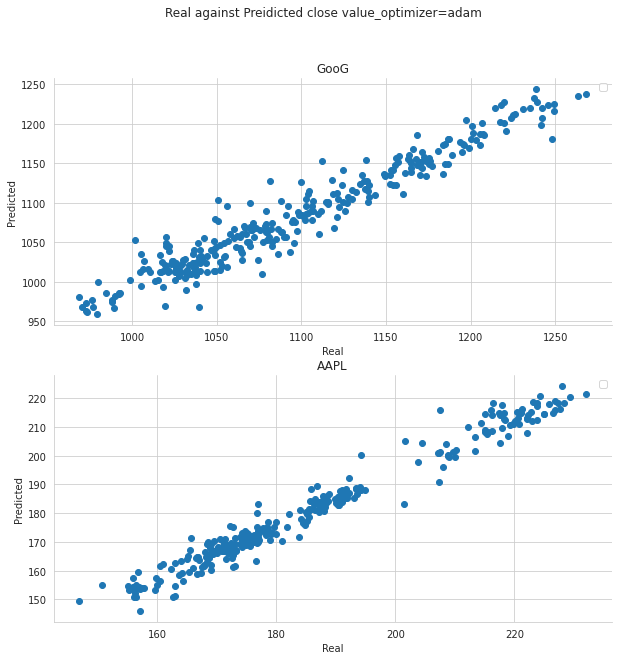

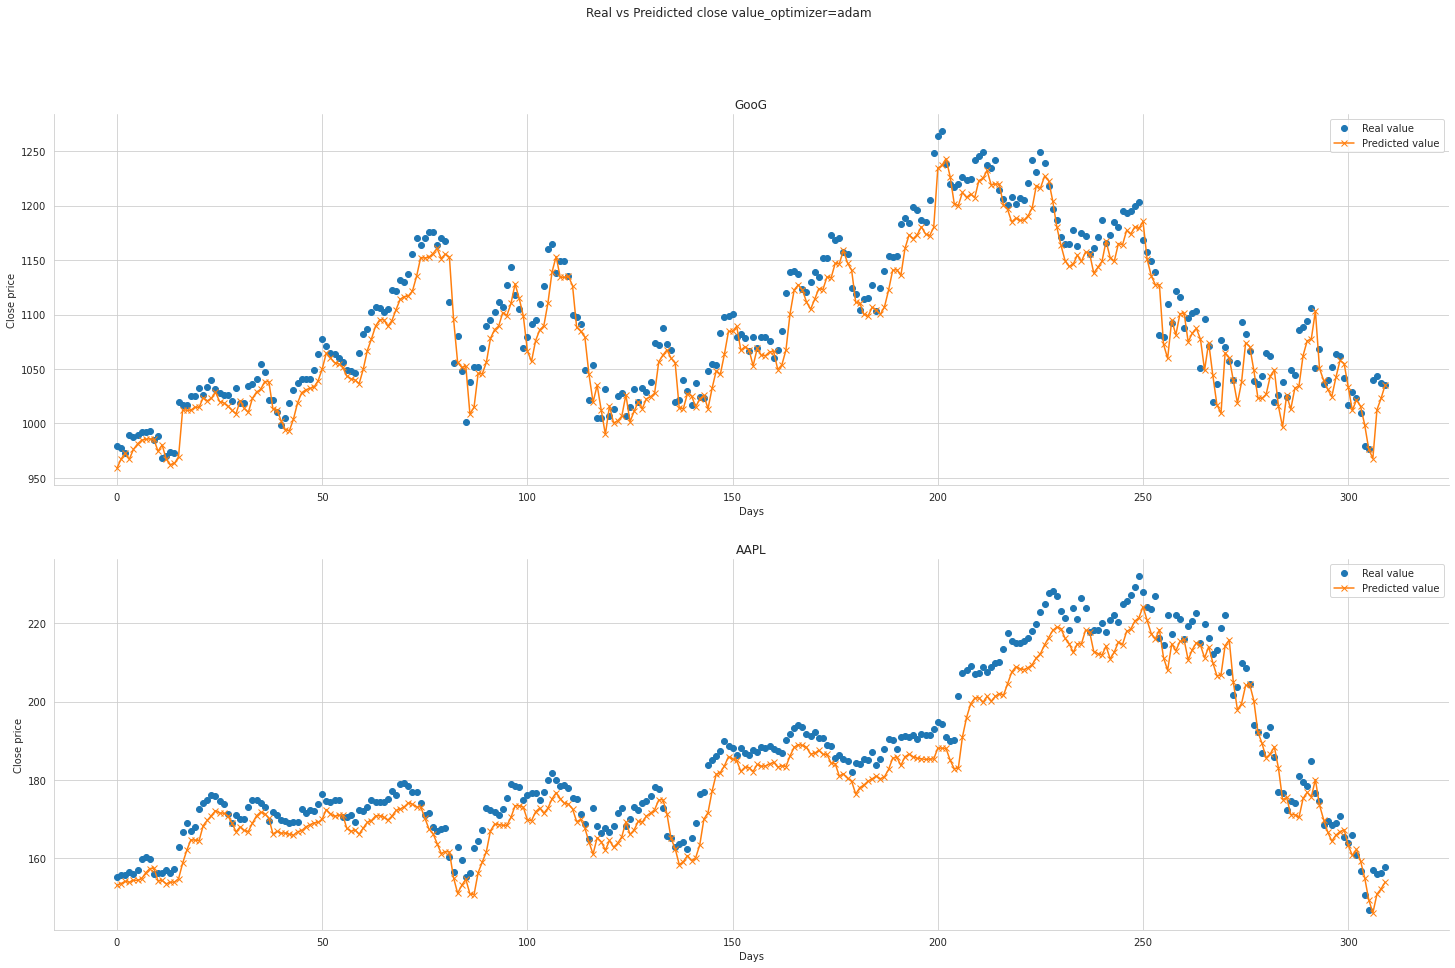

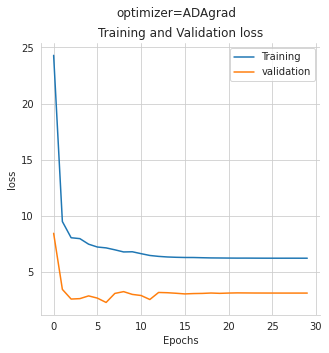

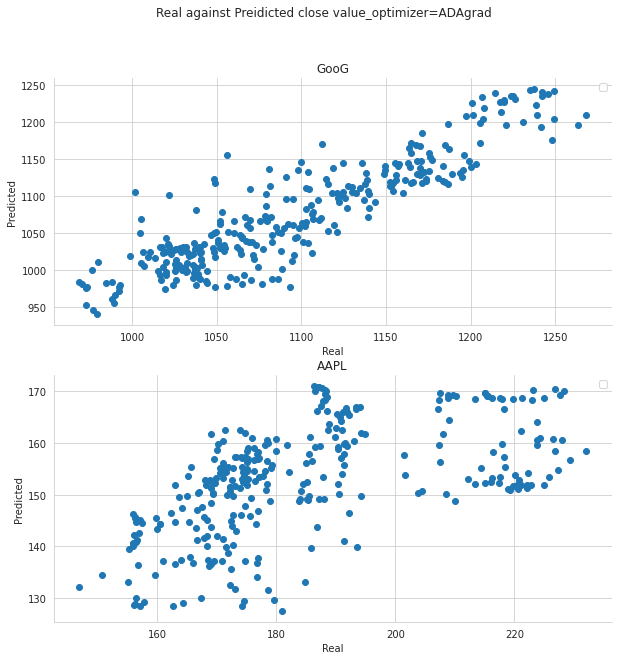

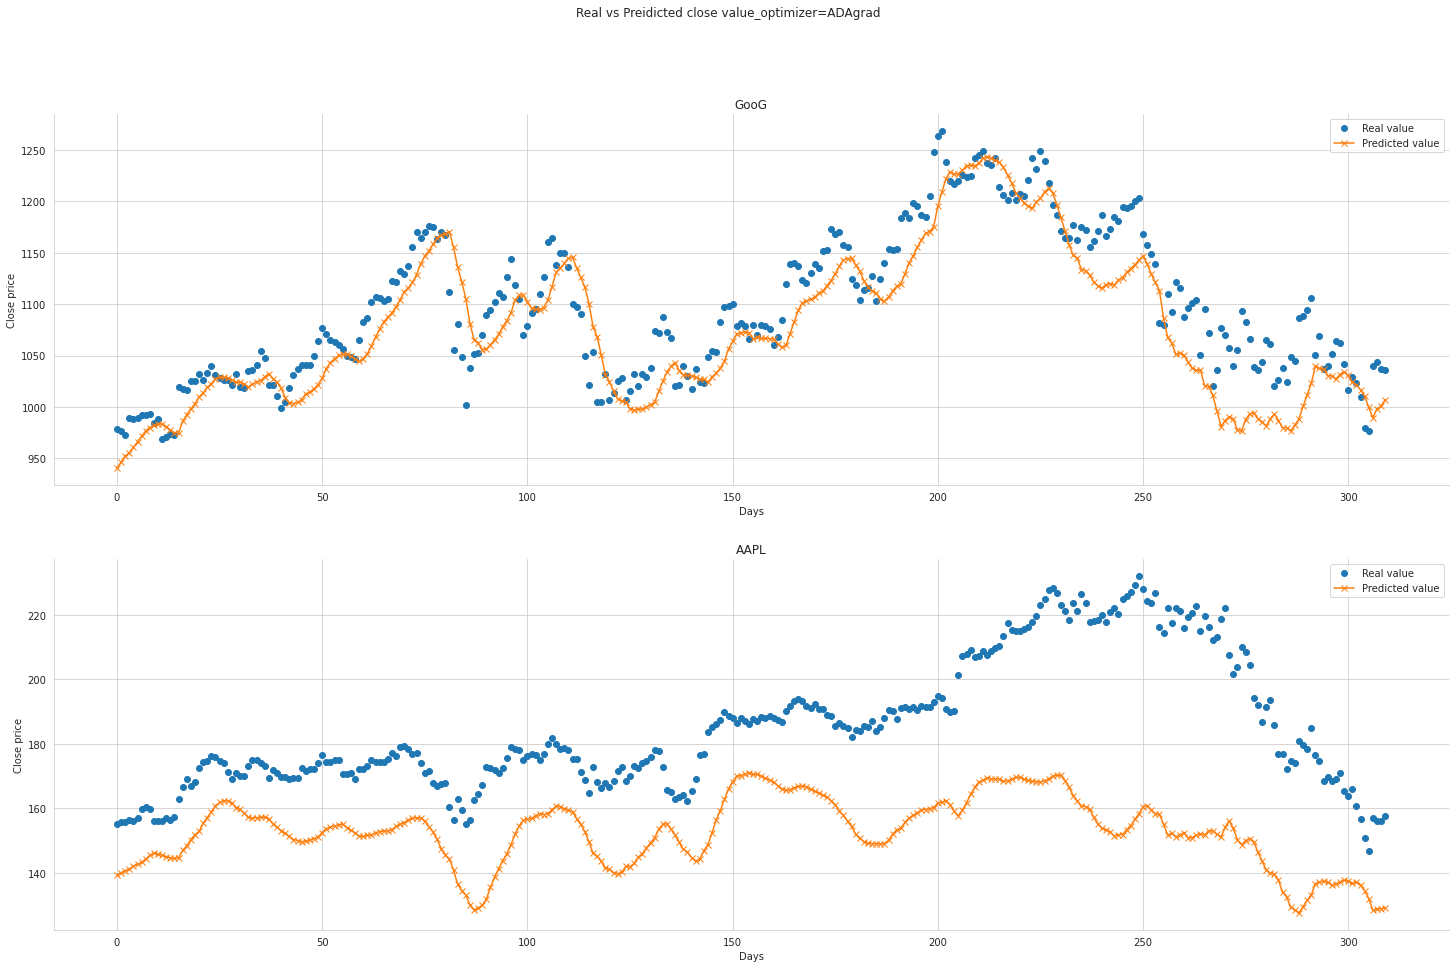

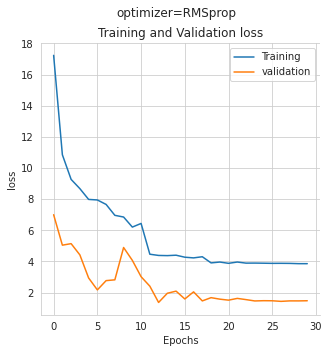

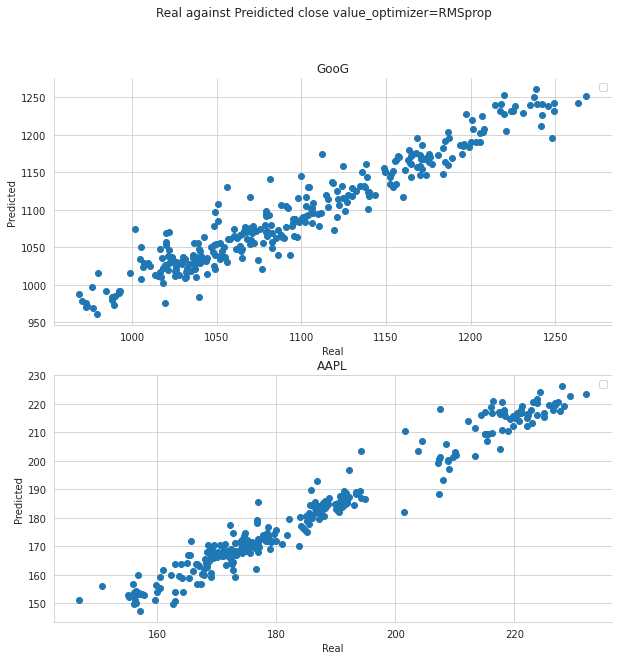

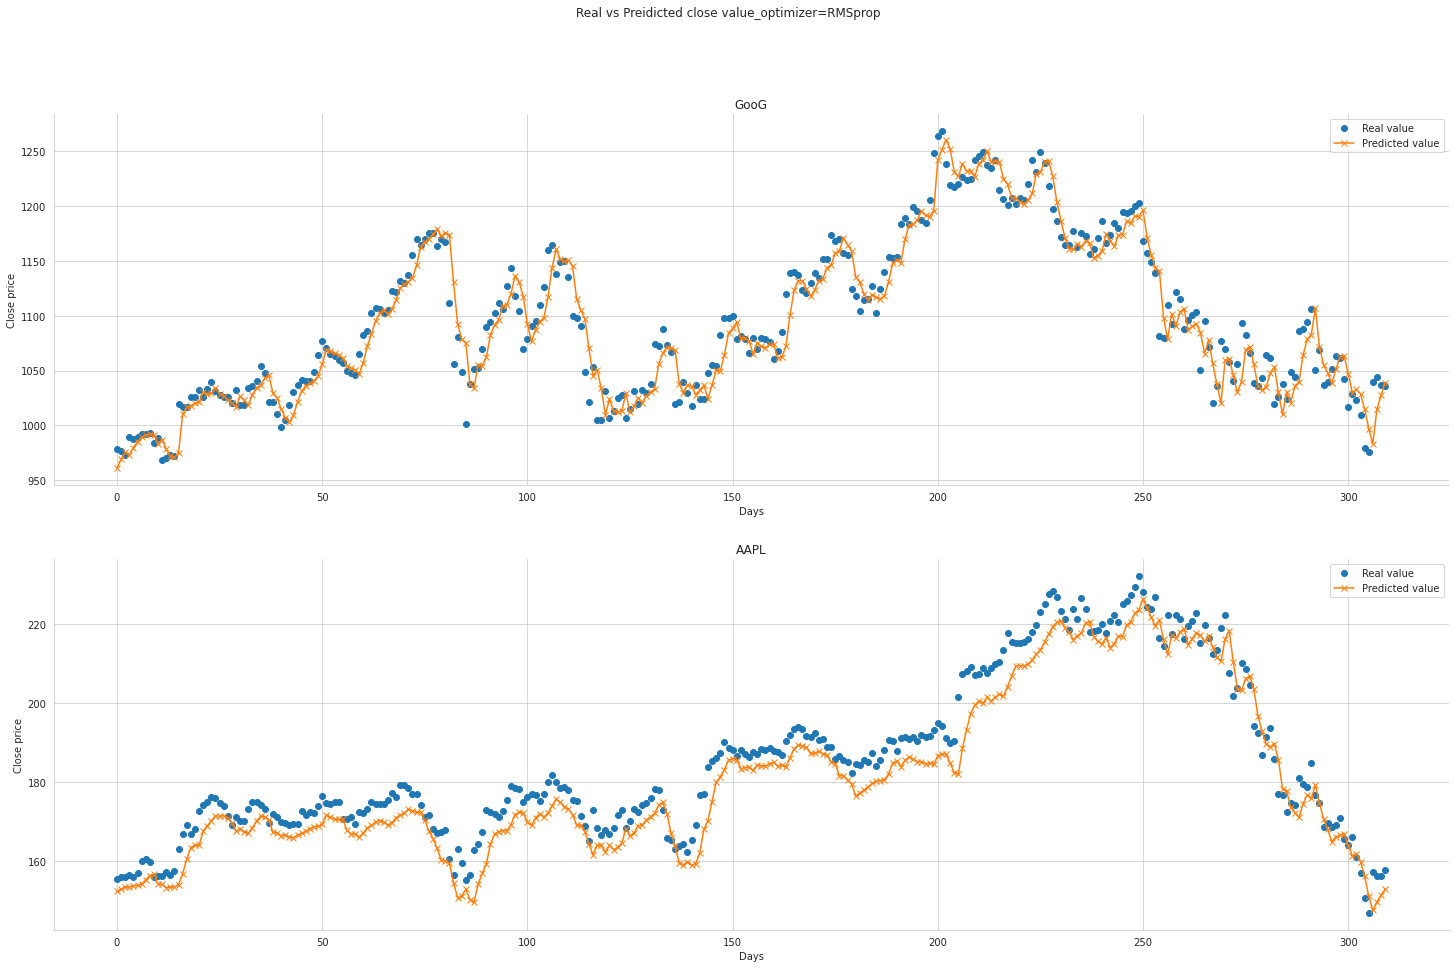

In [104]:
model_config = dict(model_name=["LSTM", "LSTM", "LSTM"], epochs=[30,30,30], batch_size=[14,14,14], activation=['relu', 'relu','relu'], optimizer=['adam','ADAgrad','RMSprop'], loss_function=['mape','mape','mape'], dropout=[0,0,0], recurrent_dropout=[0,0,0])
desired_hyper_par = "optimizer"
suptitle = "LSTM"
run_models(X_train, y_train, X_test, y_test, model_config, desired_hyper_par, suptitle)

GRU

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 100)               34200     
                                                                 
 dense_15 (Dense)            (None, 2)                 202       
                                                                 
Total params: 34,402
Trainable params: 34,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 4s 28ms/step - loss: 15.8221 - mse: 0.0134 - mape: 15.8221 - val_loss: 6.5298 - val_mse: 0.0067 - val_mape: 6.5298 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 3s 23ms/step - loss: 8.9332 - mse: 0.0014 - mape: 8.9332 - val_loss: 5.0852 - val_mse: 0.0034 - val_mape: 5.0852 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 3s 23ms/step - loss: 8.7311 -

INFO:tensorflow:Assets written to: GRUoptimizeroptimizer=adam/assets


INFO:tensorflow:Assets written to: GRUoptimizeroptimizer=adam/assets


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100)               34200     
                                                                 
 dense_16 (Dense)            (None, 2)                 202       
                                                                 
Total params: 34,402
Trainable params: 34,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 25ms/step - loss: 19.0649 - mse: 0.0122 - mape: 19.0649 - val_loss: 1.8526 - val_mse: 6.3871e-04 - val_mape: 1.8526 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 3s 23ms/step - loss: 7.9488 - mse: 6.4174e-04 - mape: 7.9488 - val_loss: 2.5416 - val_mse: 0.0010 - val_mape: 2.5416 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 2s 22ms/step - loss: 

INFO:tensorflow:Assets written to: GRUoptimizeroptimizer=ADAgrad/assets


INFO:tensorflow:Assets written to: GRUoptimizeroptimizer=ADAgrad/assets


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 100)               34200     
                                                                 
 dense_17 (Dense)            (None, 2)                 202       
                                                                 
Total params: 34,402
Trainable params: 34,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 4s 25ms/step - loss: 14.5926 - mse: 0.0073 - mape: 14.5926 - val_loss: 7.0889 - val_mse: 0.0062 - val_mape: 7.0889 - lr: 0.0010
Epoch 2/30
111/111 [==============================] - 3s 24ms/step - loss: 8.9370 - mse: 0.0011 - mape: 8.9370 - val_loss: 7.3252 - val_mse: 0.0092 - val_mape: 7.3252 - lr: 0.0010
Epoch 3/30
111/111 [==============================] - 3s 23ms/step - loss: 8.4817 -

INFO:tensorflow:Assets written to: GRUoptimizeroptimizer=RMSprop/assets


INFO:tensorflow:Assets written to: GRUoptimizeroptimizer=RMSprop/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

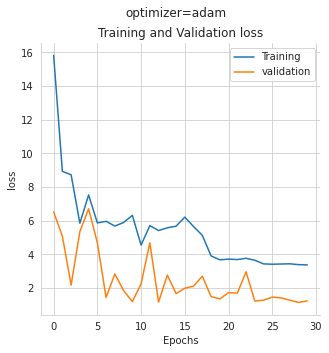

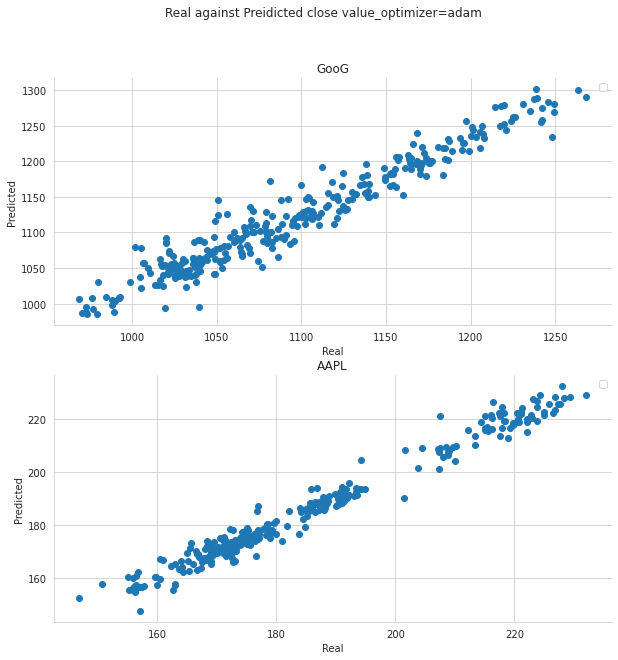

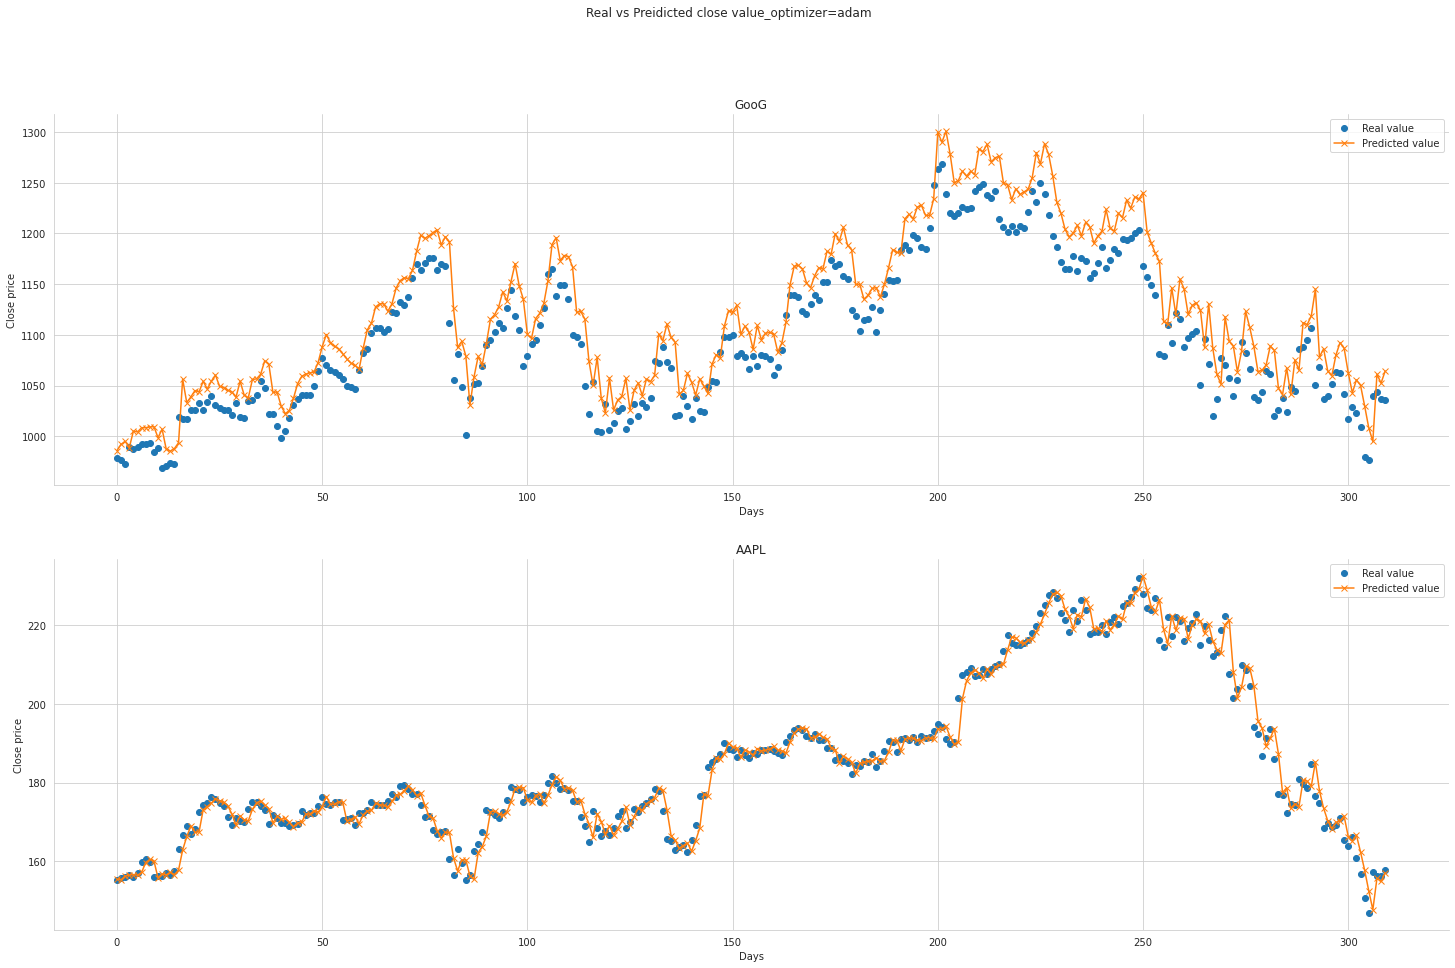

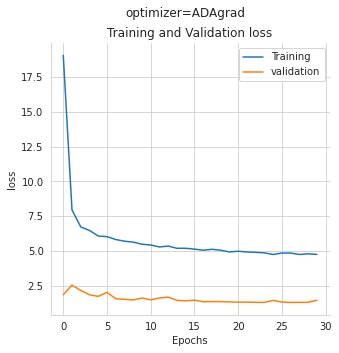

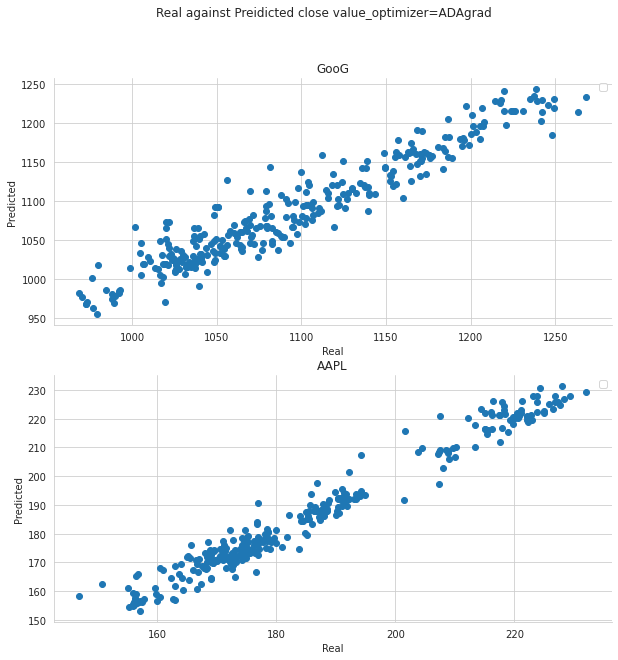

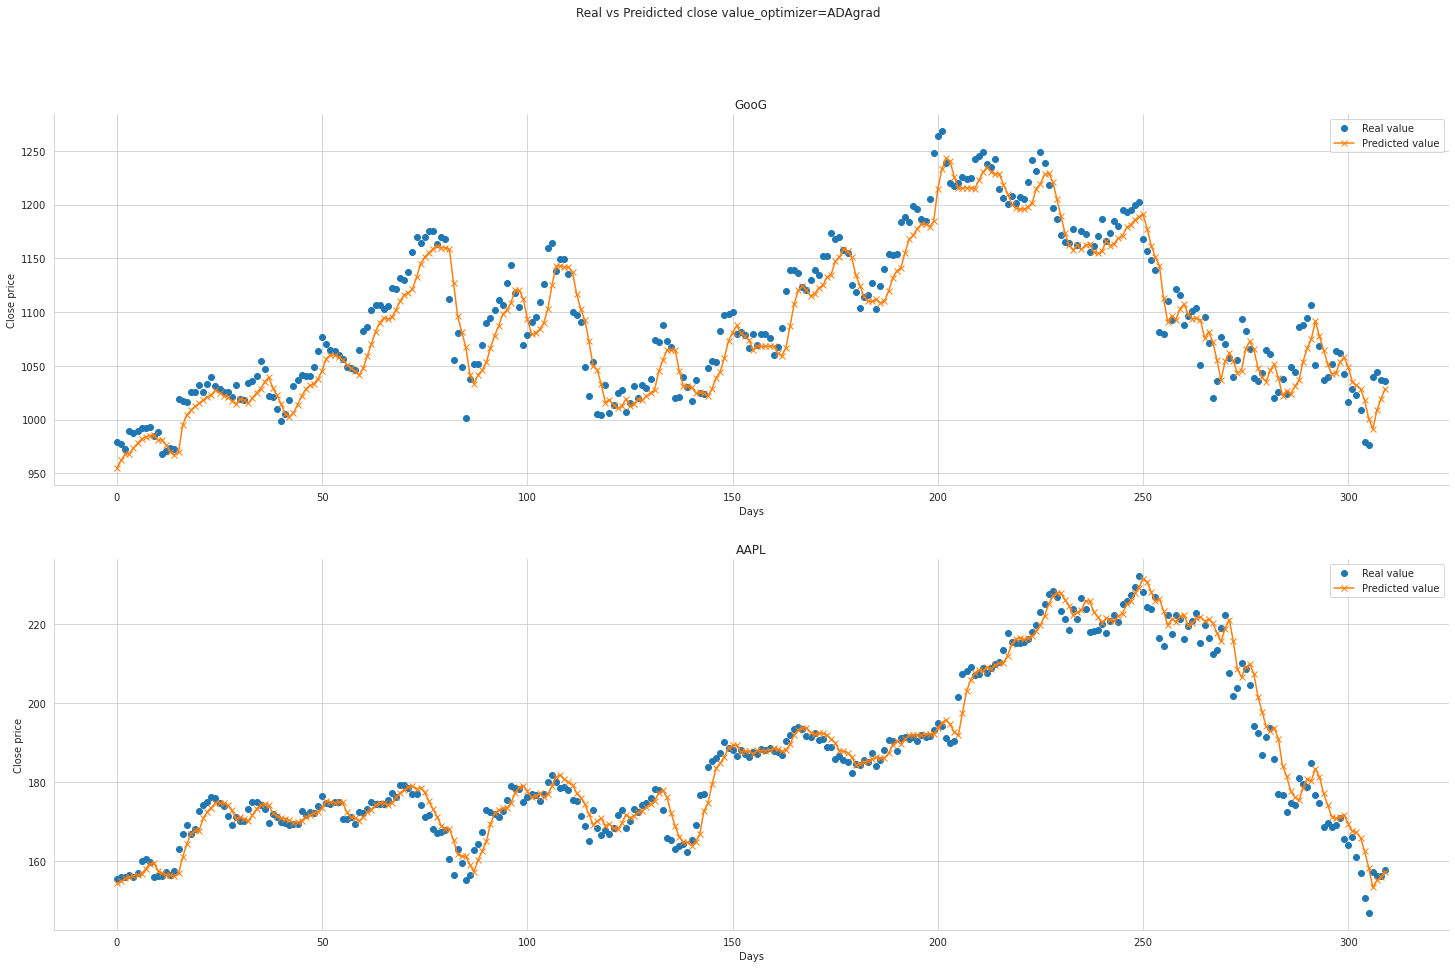

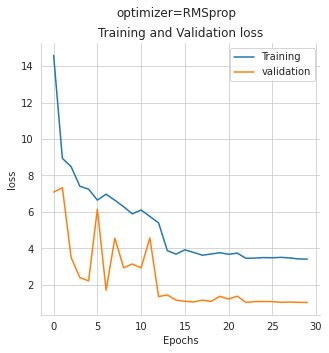

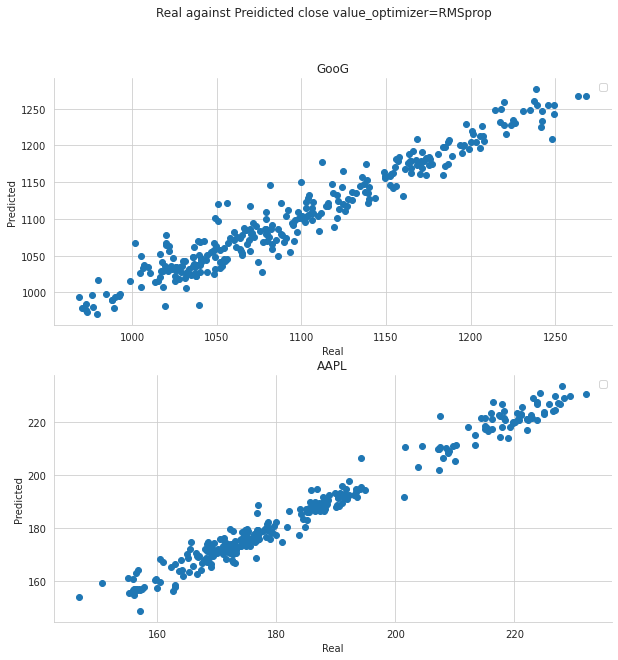

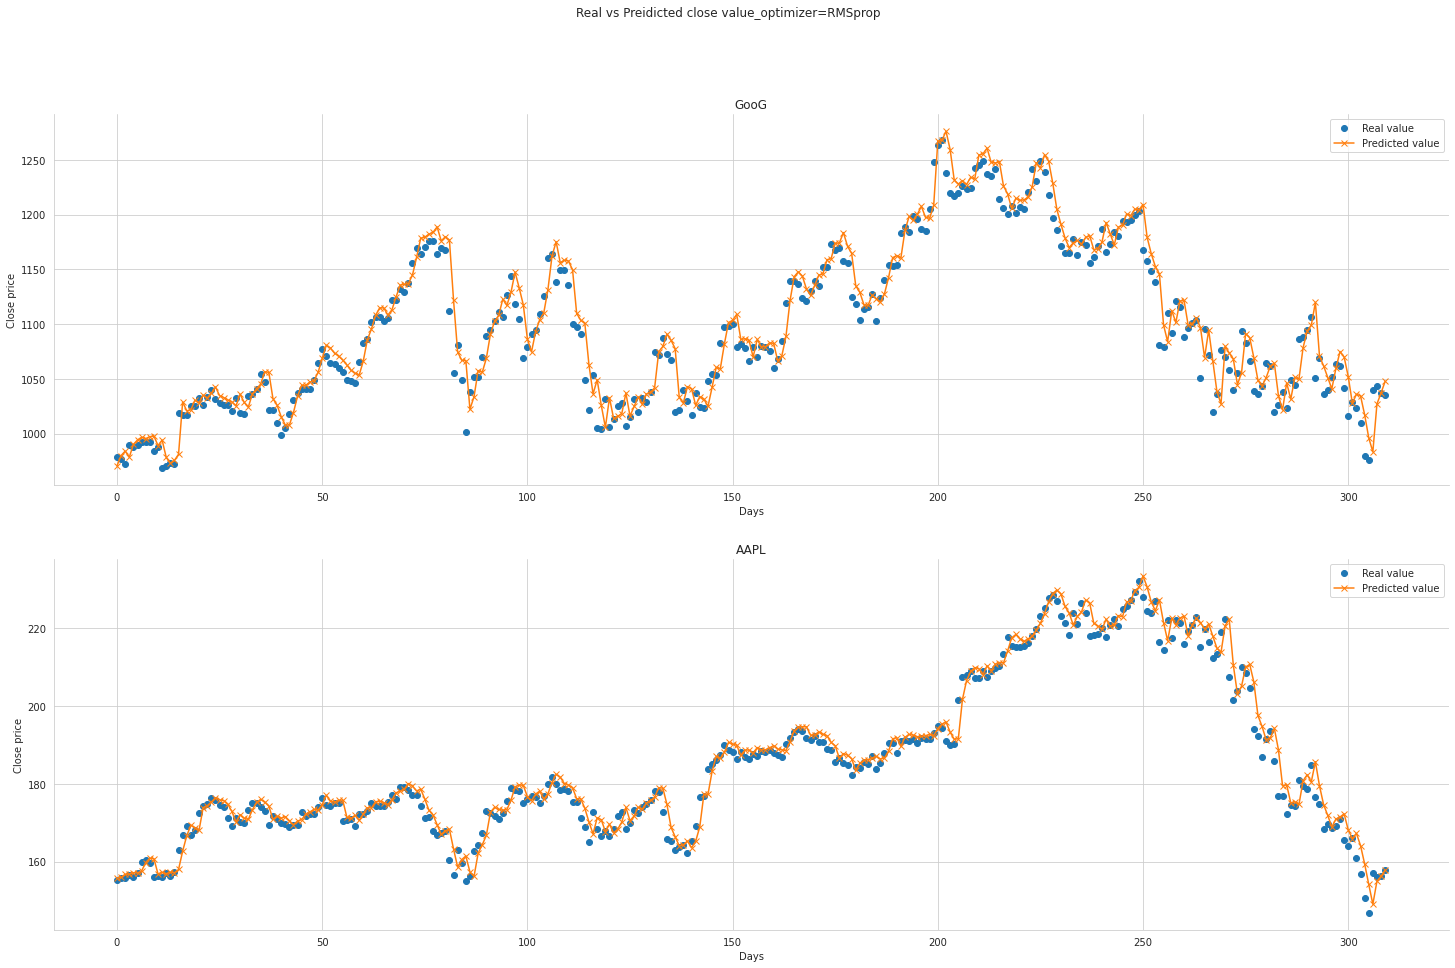

In [105]:
model_config = dict(model_name=["GRU", "GRU", "GRU"], epochs=[30,30,30], batch_size=[14,14,14], activation=['relu', 'relu','relu'], optimizer=['adam','ADAgrad','RMSprop'], loss_function=['mape','mape','mape'], dropout=[0,0,0], recurrent_dropout=[0,0,0])
desired_hyper_par = "optimizer"
suptitle = "GRU"
run_models(X_train, y_train, X_test, y_test, model_config, desired_hyper_par, suptitle)

# Dropout

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 100)               11300     
                                                                 
 dense_18 (Dense)            (None, 2)                 202       
                                                                 
Total params: 11,502
Trainable params: 11,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
111/111 [==============================] - 4s 30ms/step - loss: 29.2241 - mse: 0.0277 - mape: 29.2241 - val_loss: 5.6764 - val_mse: 0.0036 - val_mape: 5.6764 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 2s 22ms/step - loss: 13.1450 - mse: 0.0023 - mape: 13.1450 - val_loss: 5.5514 - val_mse: 0.0032 - val_mape: 5.5514 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 2s 17ms/step - loss: 10.870

INFO:tensorflow:Assets written to: dropoutmodel_namemodel_name=RNN/assets


INFO:tensorflow:Assets written to: dropoutmodel_namemodel_name=RNN/assets


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 100)               45200     
                                                                 
 dense_19 (Dense)            (None, 2)                 202       
                                                                 
Total params: 45,402
Trainable params: 45,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
111/111 [==============================] - 6s 44ms/step - loss: 17.5172 - mse: 0.0130 - mape: 17.5172 - val_loss: 3.9220 - val_mse: 0.0026 - val_mape: 3.9220 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 5s 48ms/step - loss: 8.9147 - mse: 0.0011 - mape: 8.9147 - val_loss: 14.3853 - val_mse: 0.0380 - val_mape: 14.3853 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 5s 42ms/step - loss: 8.7900

INFO:tensorflow:Assets written to: dropoutmodel_namemodel_name=LSTM/assets


INFO:tensorflow:Assets written to: dropoutmodel_namemodel_name=LSTM/assets


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 100)               34200     
                                                                 
 dense_20 (Dense)            (None, 2)                 202       
                                                                 
Total params: 34,402
Trainable params: 34,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
111/111 [==============================] - 6s 45ms/step - loss: 20.2004 - mse: 0.0189 - mape: 20.2004 - val_loss: 3.3298 - val_mse: 0.0014 - val_mape: 3.3298 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 5s 42ms/step - loss: 9.1609 - mse: 0.0012 - mape: 9.1609 - val_loss: 3.8670 - val_mse: 0.0027 - val_mape: 3.8670 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 5s 42ms/step - loss: 6.6343 -

INFO:tensorflow:Assets written to: dropoutmodel_namemodel_name=GRU/assets


INFO:tensorflow:Assets written to: dropoutmodel_namemodel_name=GRU/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

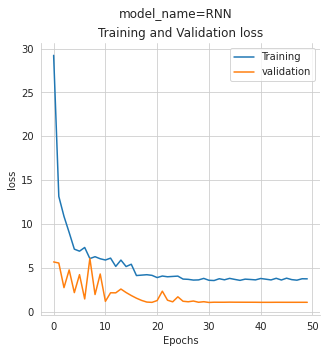

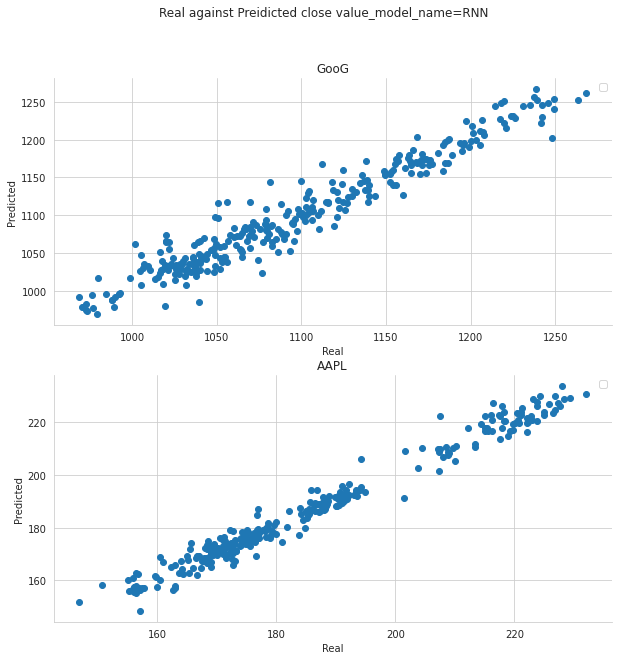

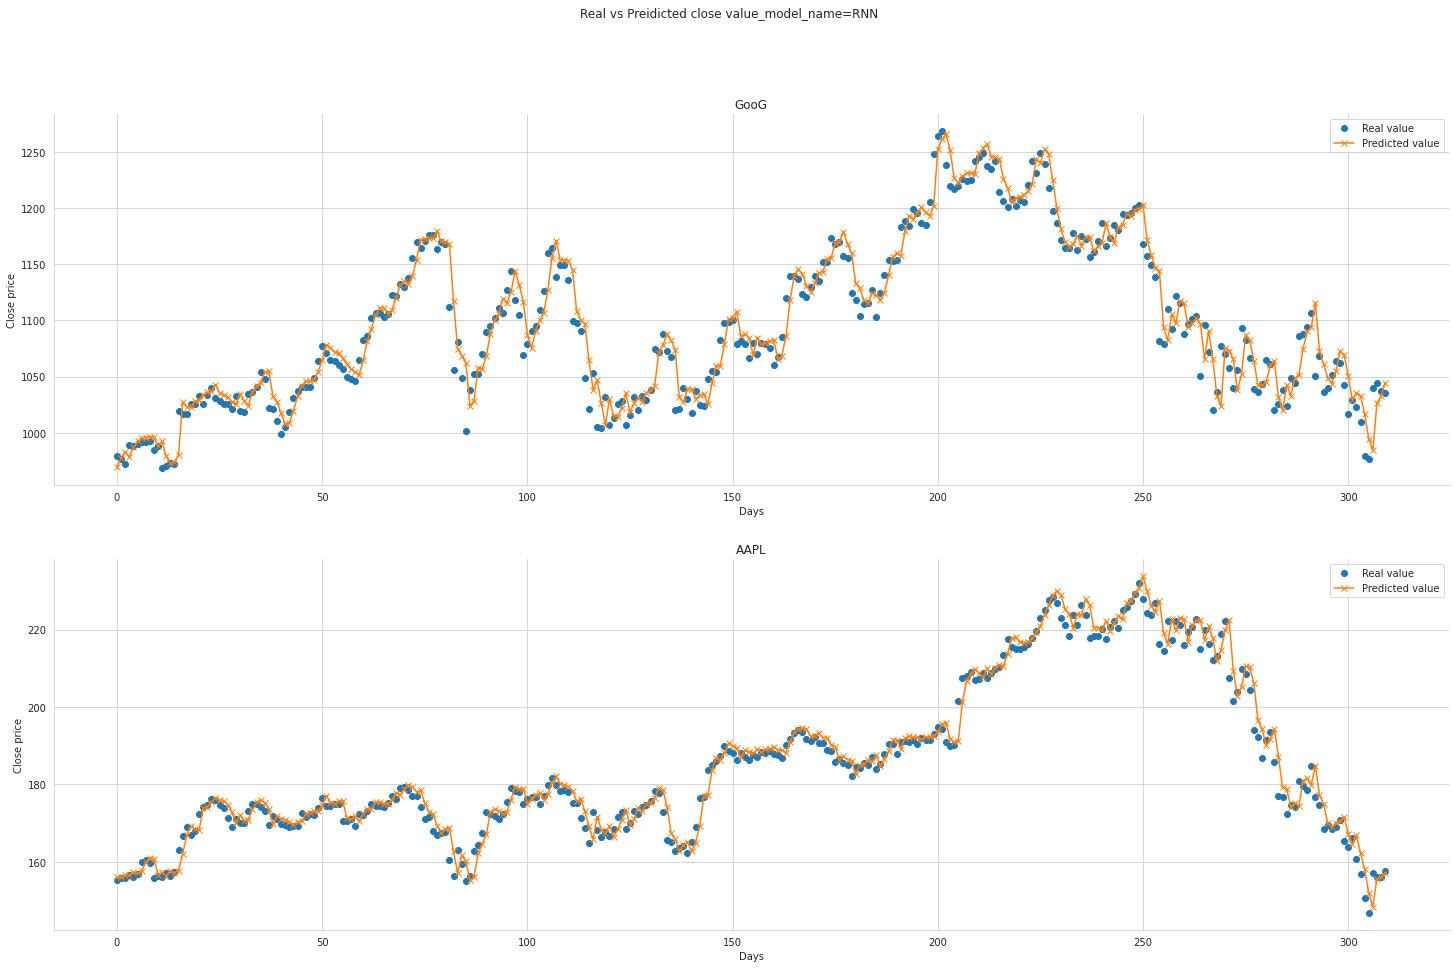

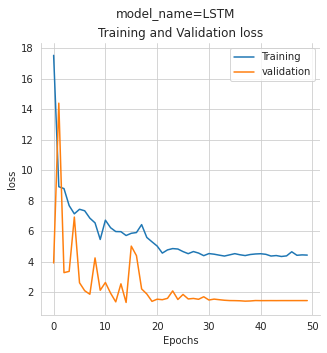

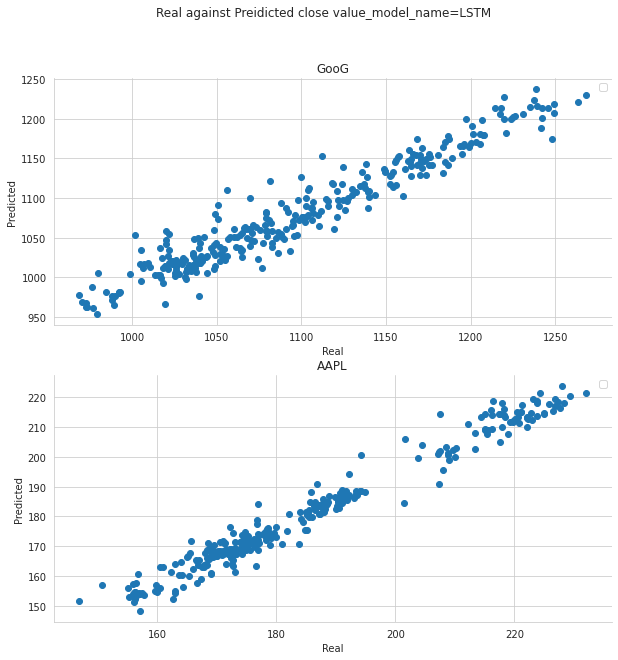

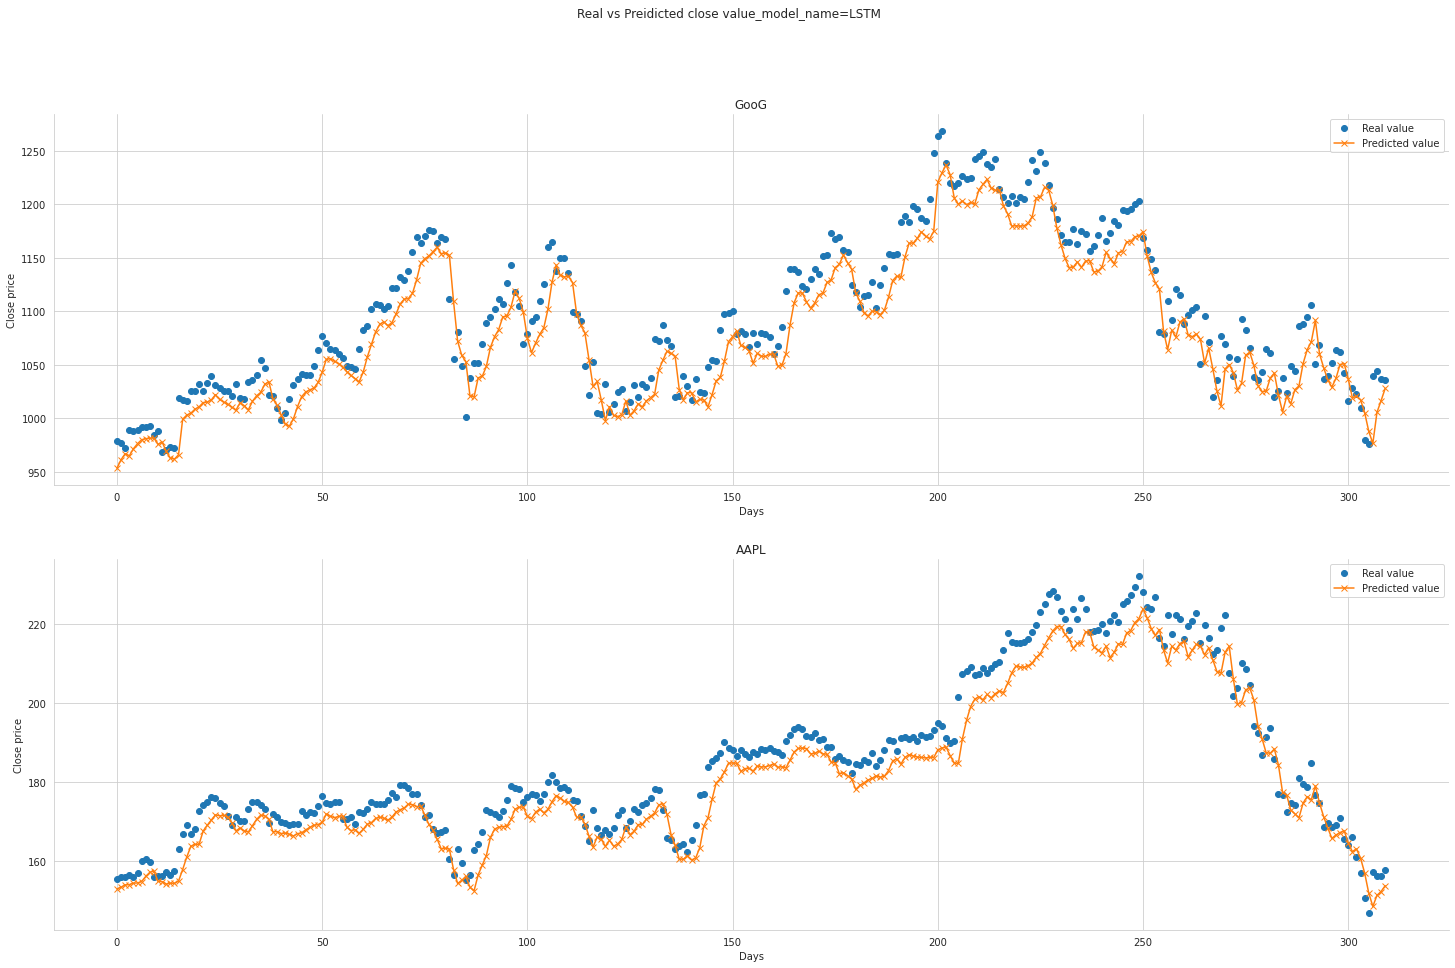

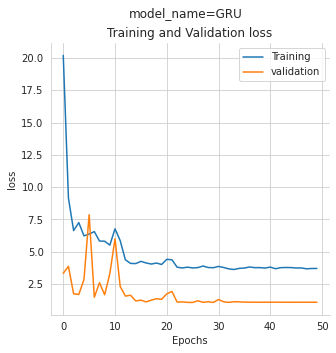

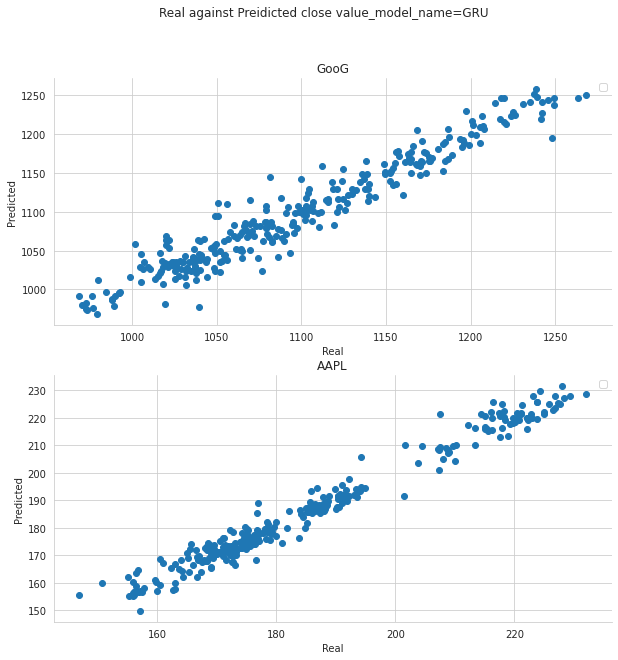

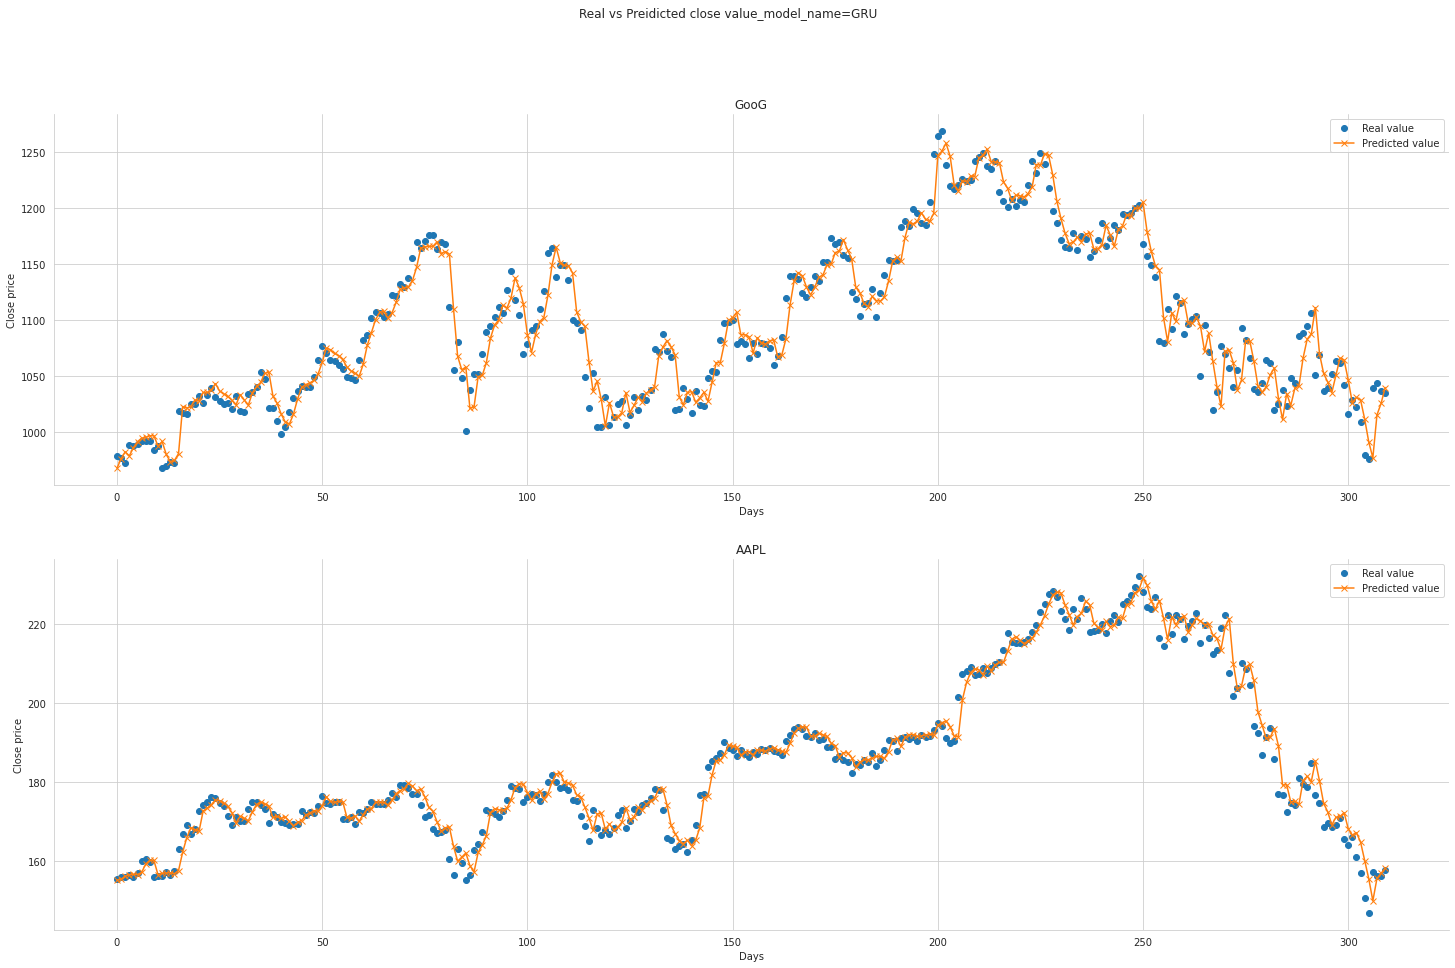

In [106]:
model_config = dict(model_name=["RNN", "LSTM", "GRU"], epochs=[50, 50,50], batch_size=[14,14,14], activation=['relu', 'relu','relu'], optimizer=['adam','adam','adam'], loss_function=['mape','mape','mape'], dropout=[0,0,0], recurrent_dropout=[0.2,0.2,0.2])
desired_hyper_par = "model_name"
suptitle = "dropout"
run_models(X_train, y_train, X_test, y_test, model_config, desired_hyper_par, suptitle)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 100)               11300     
                                                                 
 dense_24 (Dense)            (None, 2)                 202       
                                                                 
Total params: 11,502
Trainable params: 11,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
111/111 [==============================] - 4s 22ms/step - loss: 42.5395 - mse: 0.0425 - mape: 42.5395 - val_loss: 16.3472 - val_mse: 0.0268 - val_mape: 16.3472 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 2s 17ms/step - loss: 14.0947 - mse: 0.0039 - mape: 14.0947 - val_loss: 5.1783 - val_mse: 0.0035 - val_mape: 5.1783 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 2s 18ms/step - loss: 10.9

INFO:tensorflow:Assets written to: dropout-0.5model_namemodel_name=RNN/assets


INFO:tensorflow:Assets written to: dropout-0.5model_namemodel_name=RNN/assets


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               45200     
                                                                 
 dense_25 (Dense)            (None, 2)                 202       
                                                                 
Total params: 45,402
Trainable params: 45,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
111/111 [==============================] - 6s 45ms/step - loss: 20.8531 - mse: 0.0137 - mape: 20.8531 - val_loss: 4.1846 - val_mse: 0.0027 - val_mape: 4.1846 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 5s 42ms/step - loss: 7.9930 - mse: 8.4528e-04 - mape: 7.9930 - val_loss: 3.0138 - val_mse: 0.0013 - val_mape: 3.0138 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 5s 43ms/step - loss: 8.39

INFO:tensorflow:Assets written to: dropout-0.5model_namemodel_name=LSTM/assets


INFO:tensorflow:Assets written to: dropout-0.5model_namemodel_name=LSTM/assets


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 100)               34200     
                                                                 
 dense_26 (Dense)            (None, 2)                 202       
                                                                 
Total params: 34,402
Trainable params: 34,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
111/111 [==============================] - 6s 45ms/step - loss: 19.8652 - mse: 0.0187 - mape: 19.8652 - val_loss: 2.8443 - val_mse: 0.0013 - val_mape: 2.8443 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - 5s 42ms/step - loss: 8.4440 - mse: 9.2843e-04 - mape: 8.4440 - val_loss: 2.0810 - val_mse: 9.2062e-04 - val_mape: 2.0810 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - 5s 42ms/step - loss: 

INFO:tensorflow:Assets written to: dropout-0.5model_namemodel_name=GRU/assets


INFO:tensorflow:Assets written to: dropout-0.5model_namemodel_name=GRU/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

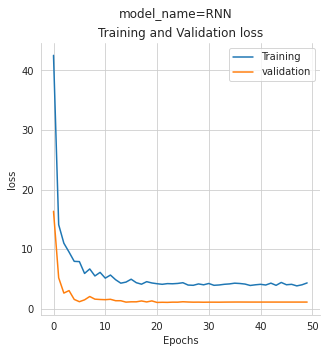

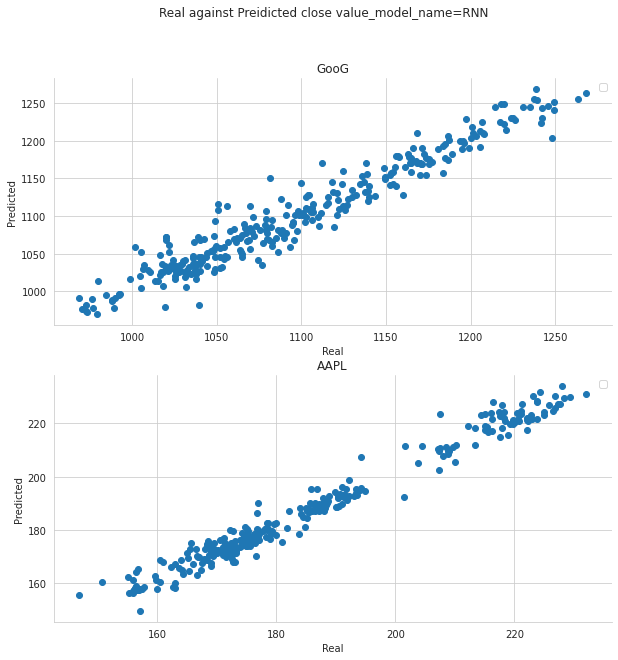

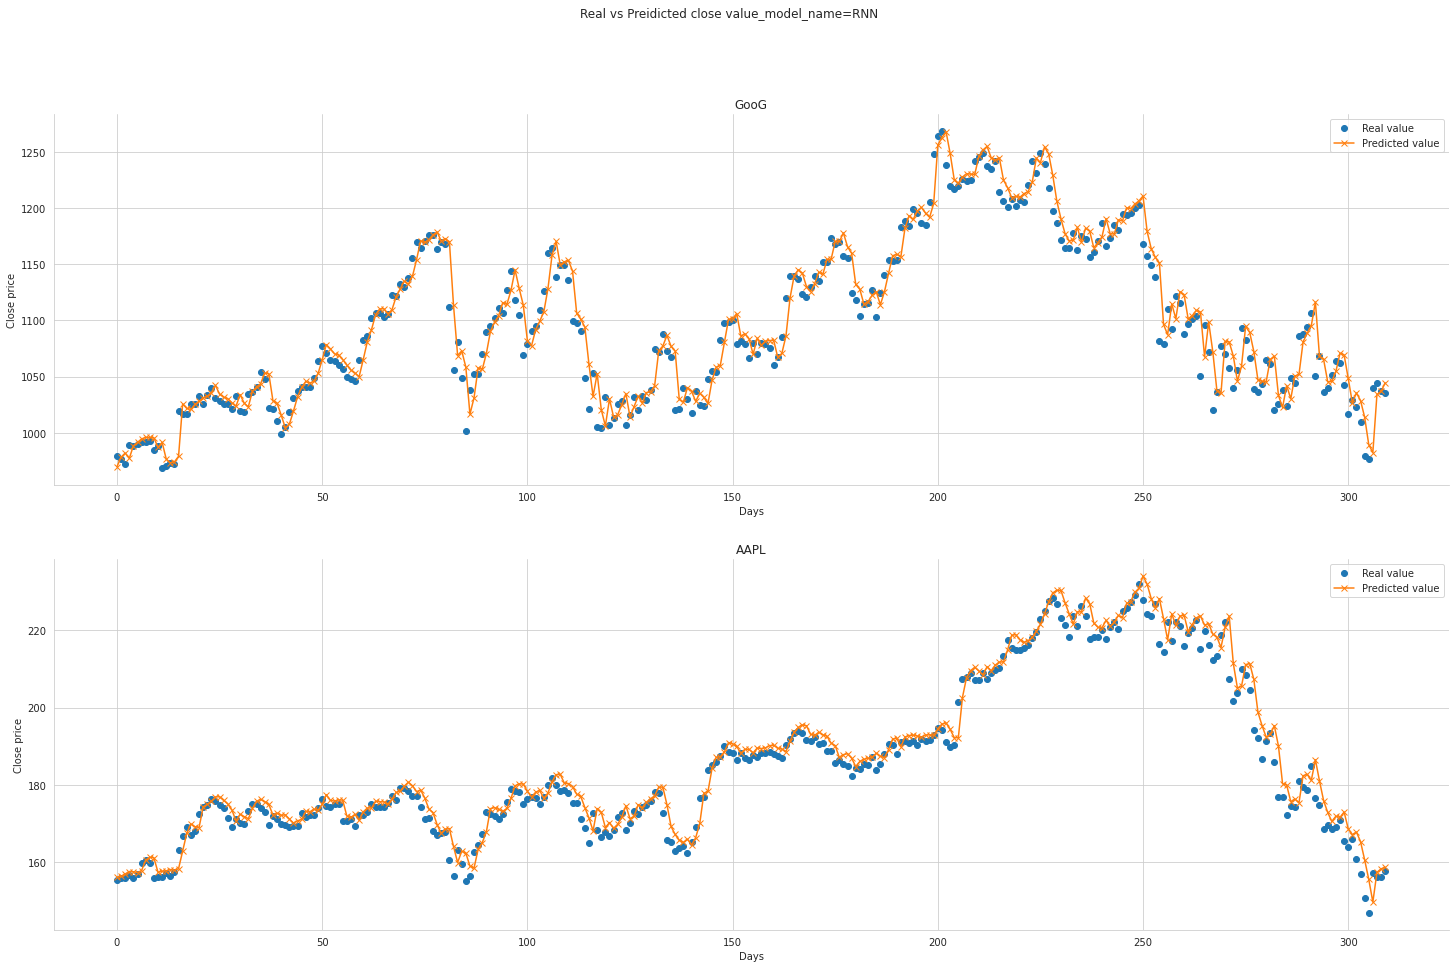

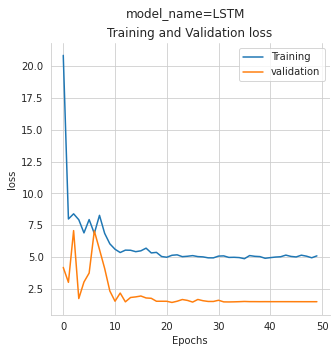

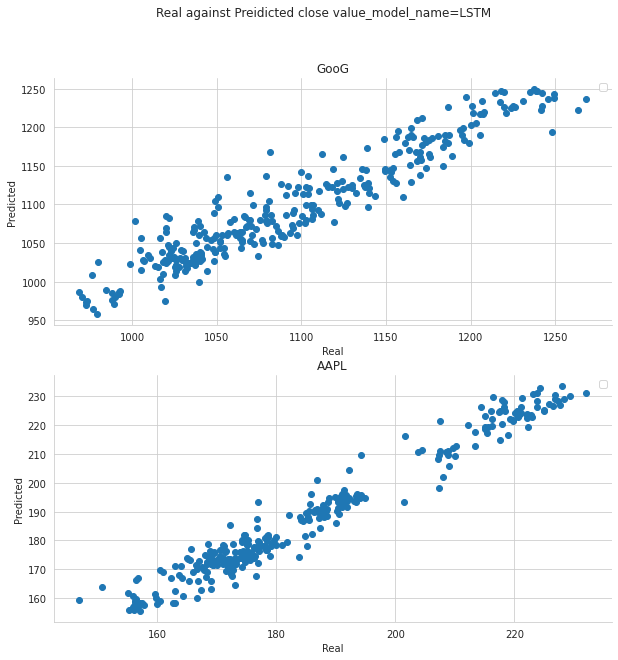

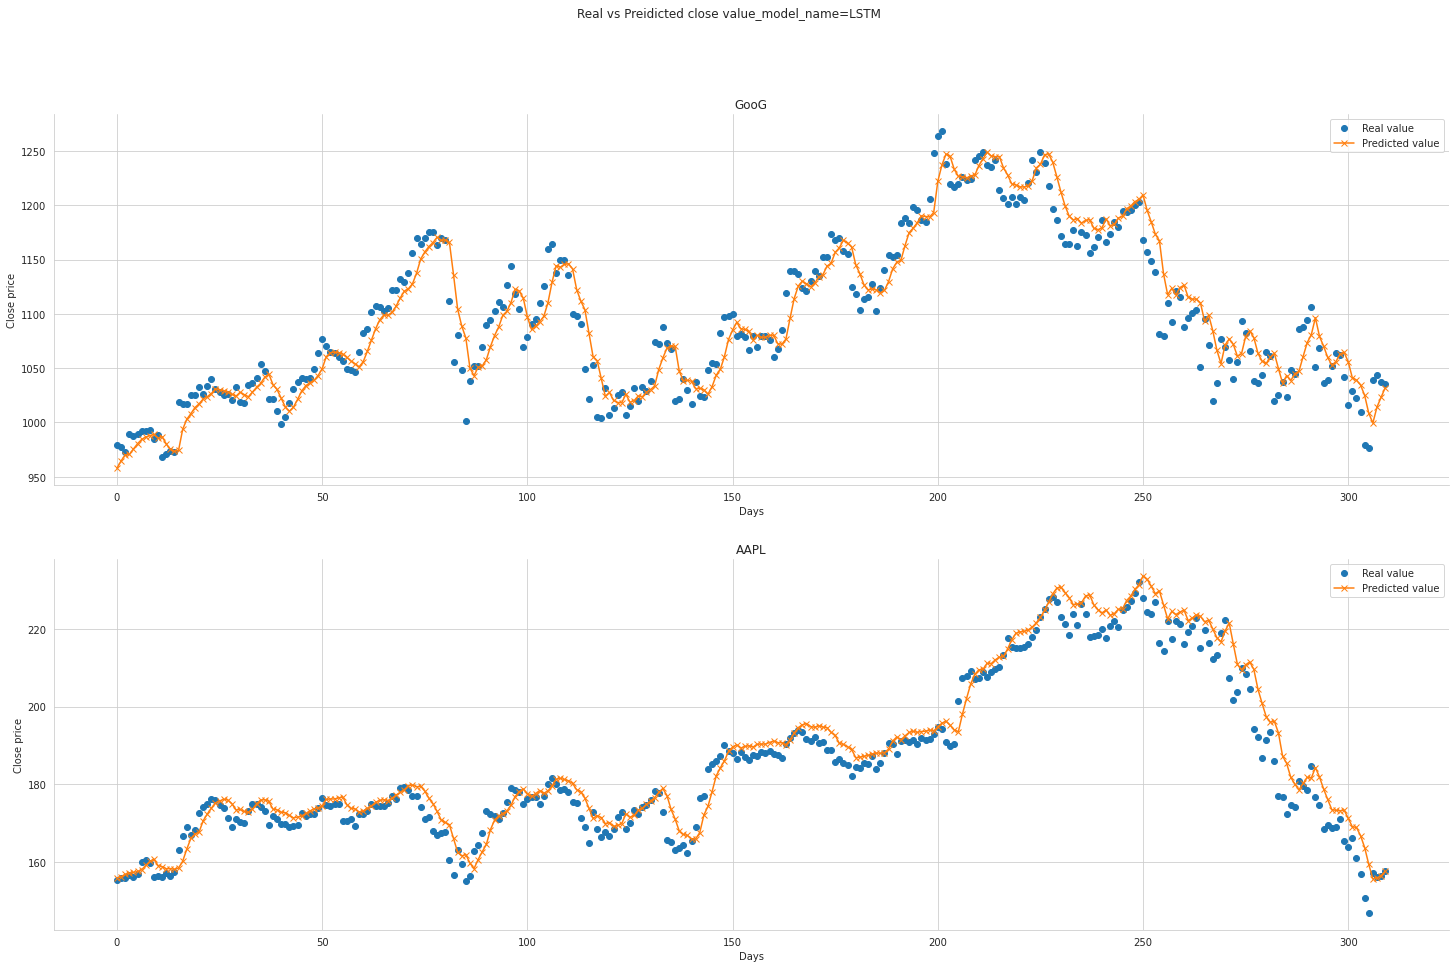

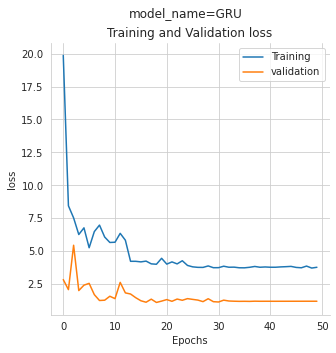

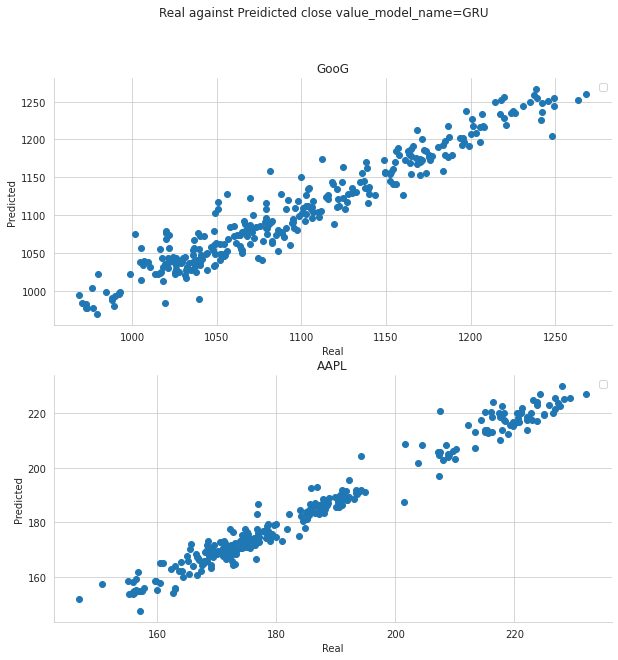

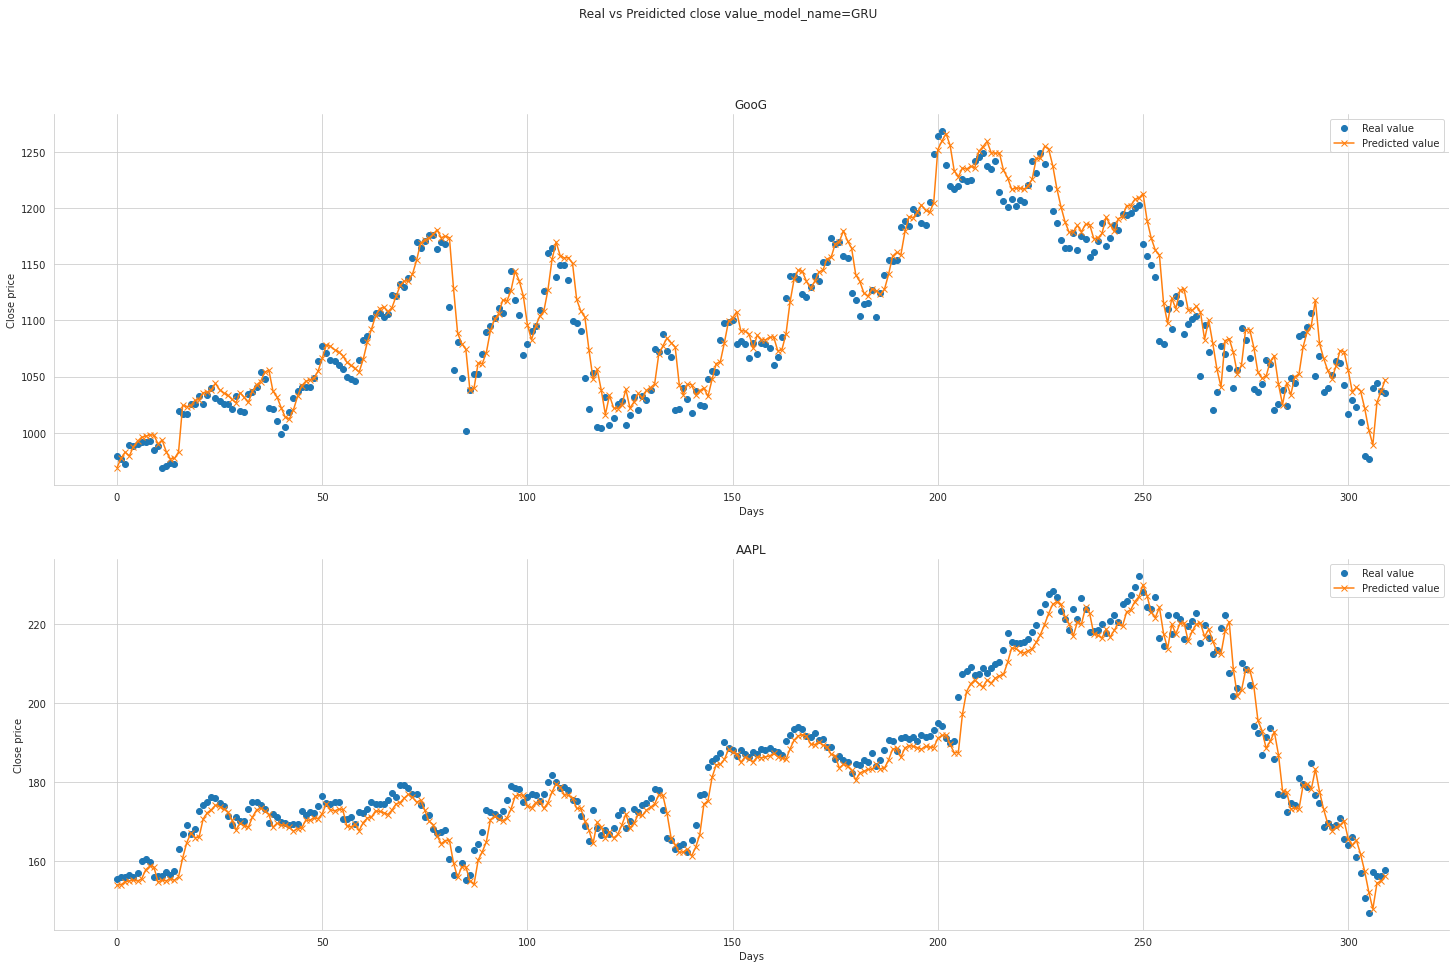

In [109]:
model_config = dict(model_name=["RNN", "LSTM", "GRU"], epochs=[50, 50,50], batch_size=[14,14,14], activation=['relu', 'relu','relu'], optimizer=['adam','adam','adam'], loss_function=['mape','mape','mape'], dropout=[0,0,0], recurrent_dropout=[0.5,0.5,0.5])
desired_hyper_par = "model_name"
suptitle = "dropout-0.5"
run_models(X_train, y_train, X_test, y_test, model_config, desired_hyper_par, suptitle)